In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs/AAPL_1_base.csv


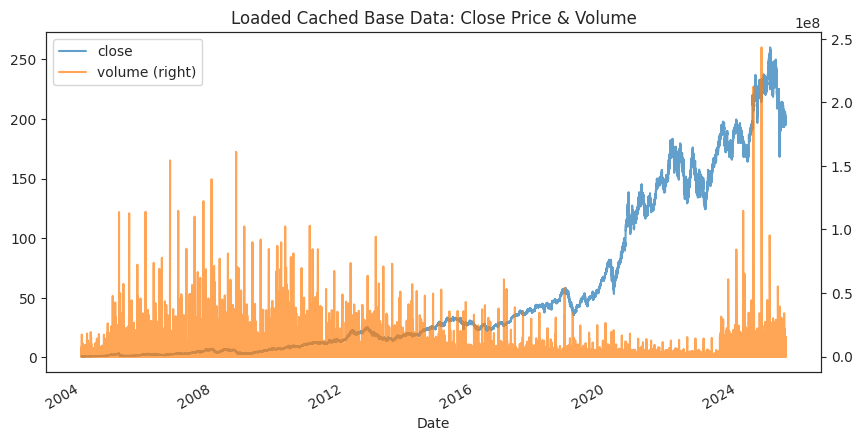

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [3]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def saveDF_checkDAY(
    df: pd.DataFrame,
    best_optuna_params: Dict
) -> pd.DataFrame:
    """
    1) Slice df to the month in params.month_to_check ("YYYY-MM").
    2) Run the optimized pipeline over that month’s data:
       - The pipeline itself will group and simulate day by day.
       - Plot each day’s trades & equity.
       - Print per-day performance.
    3) If params.createCSVsign:
       • Rerun pipeline on the full df, aggregate & plot.
       • Save the full-run signals CSV.
       • Return the full-run DataFrame.
    4) Otherwise return the month’s concatenated signals/actions DataFrame.
    """
    # 1) Filter to the chosen month
    month_str = params.month_to_check    # e.g. "2023-09"
    print(f"\n=== Running pipeline for month {month_str} ===")

    # mask all rows whose index formatted as "YYYY-MM" equals month_to_check
    df_period = df[df.index.strftime("%Y-%m") == month_str].copy()
    if df_period.empty:
        print("No market data for this month; returning empty DataFrame.")
        return pd.DataFrame()

    # 2) Run pipeline on entire month slice
    result_by_day = trades.run_trading_pipeline(
        df           = df_period,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )
    if not result_by_day:
        print("No trades generated in this period; returning empty DataFrame.")
        return pd.DataFrame()

    # Unpack per-day results for plotting & stats
    month_frames = []
    month_stats  = []
    for day, (df_day, trades_day, perf_day) in result_by_day.items():
        print(f"-------------------------------------------------------------------------------------------------------------------------------------------------")
        plots.plot_trades(
            df                 = df_day,
            col_signal1        = "signal",
            col_signal2        = False,
            col_action         = "signal_action",
            trades             = trades_day,
            buy_threshold      = best_optuna_params["buy_threshold"],
            performance_stats  = perf_day,
            start_plot         = params.sess_start
        )
        for k, v in perf_day.items():
            print(f"  {k}: {v}")

        month_frames.append(df_day)
        month_stats.append(perf_day)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)
    
    # If not saving full-run CSV, just return the month’s results
    if not params.createCSVsign:
        return df_month

    # 3) Full-run backtest (same as before)
    print("\n******************** Running pipeline on full dataset ********************")
    full_results = trades.run_trading_pipeline(
        df           = df,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )

    # Build combined DF & perf list
    daily_frames = [res[0] for res in full_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_results.values()]
    plots.aggregate_performance(perf_all, df_all)

    # Test-period slice & performance
    all_days  = df_all.index.normalize().unique()
    cutoff    = int(len(all_days) * (params.train_prop + params.val_prop))
    test_days = all_days[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print(f"\nSaving full-run signals to {params.sign_csv} …")
    df_all.to_csv(params.sign_csv)
    print("CSV saved.")

    return df_all


best_optuna_value: 0.5146022222222223
best_optuna_params: {'min_prof_thr': 0.0342901435860898, 'max_down_prop': 0.90238165742582, 'gain_tightening_factor': 24.95286835227118, 'merging_retracement_thr': 0.49969219278242316, 'merging_time_gap_thr': 3.236169274940038, 'tau_time': 13, 'tau_dur': 204, 'trailing_stop_pct': 0.037492180108668366, 'buy_threshold': 0.3615539306704394, 'smoothing_window': 15}

=== Running pipeline for month 2023-10 ===
Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 3.36 ) & generating trade actions …


Simulating trading days: 100%|██████████| 22/22 [00:01<00:00, 17.32day/s]


-------------------------------------------------------------------------------------------------------------------------------------------------


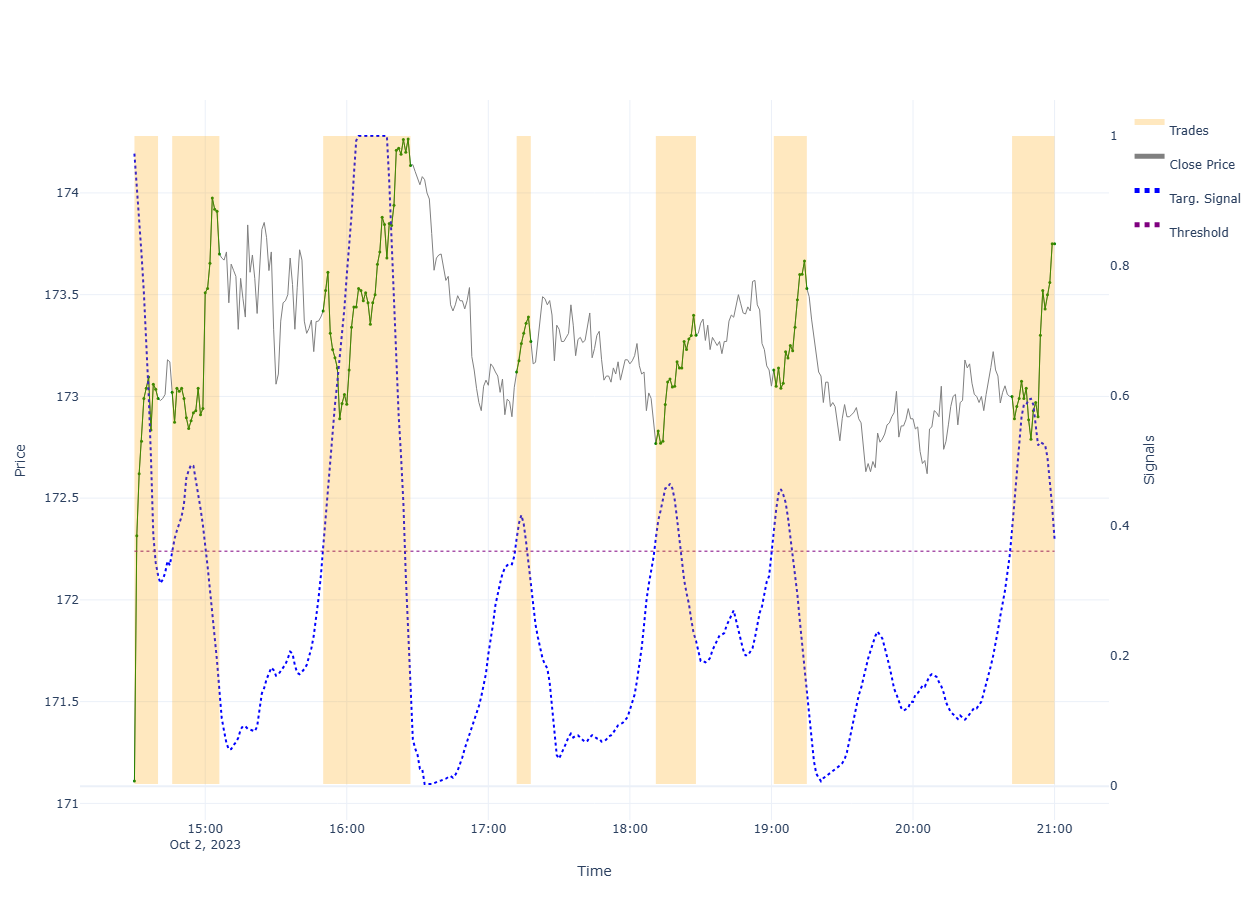

  Buy & Hold Return ($): 2.381
  Strategy Return ($): 3.288
  Trades Returns ($): [1.622, 0.421, 0.455, -0.109, 0.271, 0.14, 0.49]
-------------------------------------------------------------------------------------------------------------------------------------------------


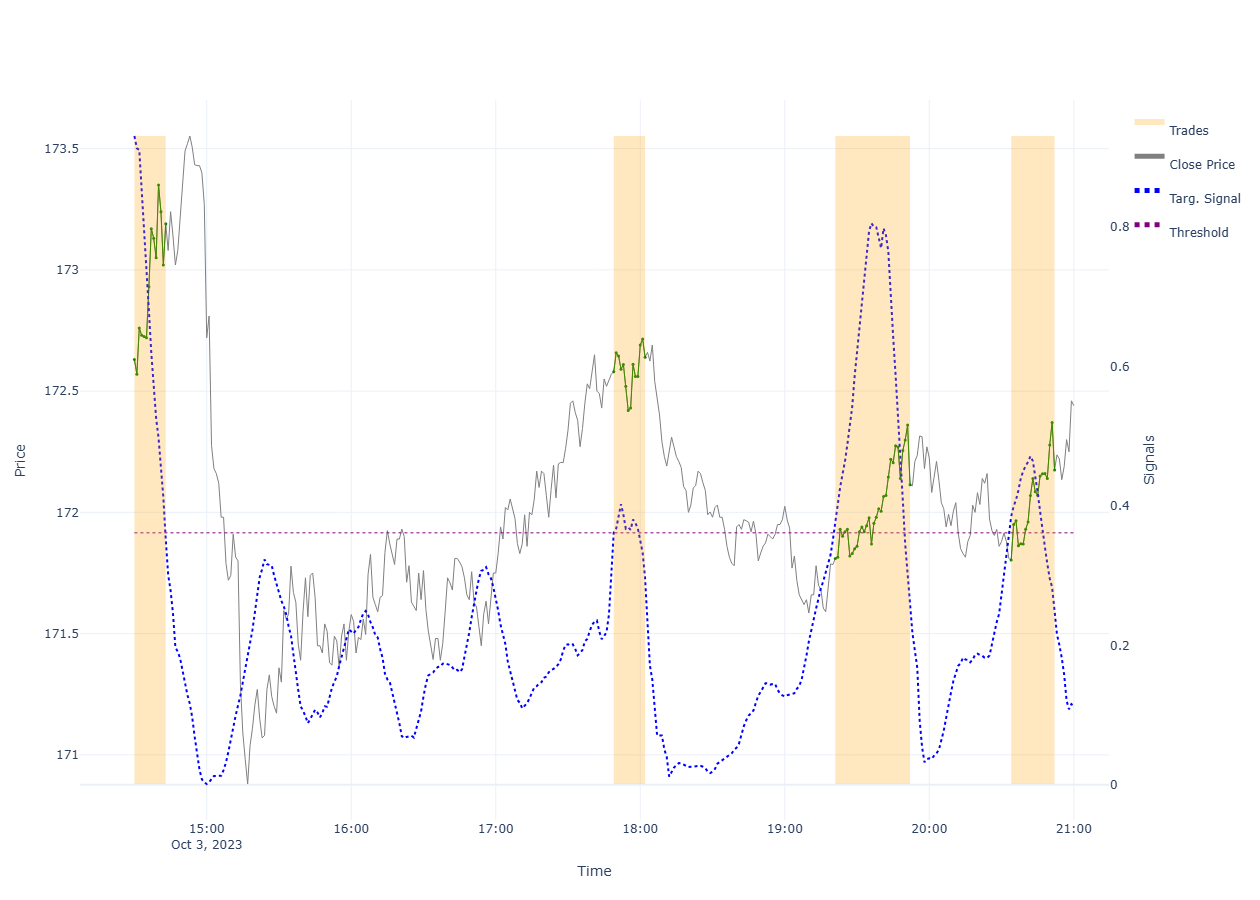

  Buy & Hold Return ($): -0.449
  Strategy Return ($): 0.262
  Trades Returns ($): [0.301, -0.199, 0.046, 0.113]
-------------------------------------------------------------------------------------------------------------------------------------------------


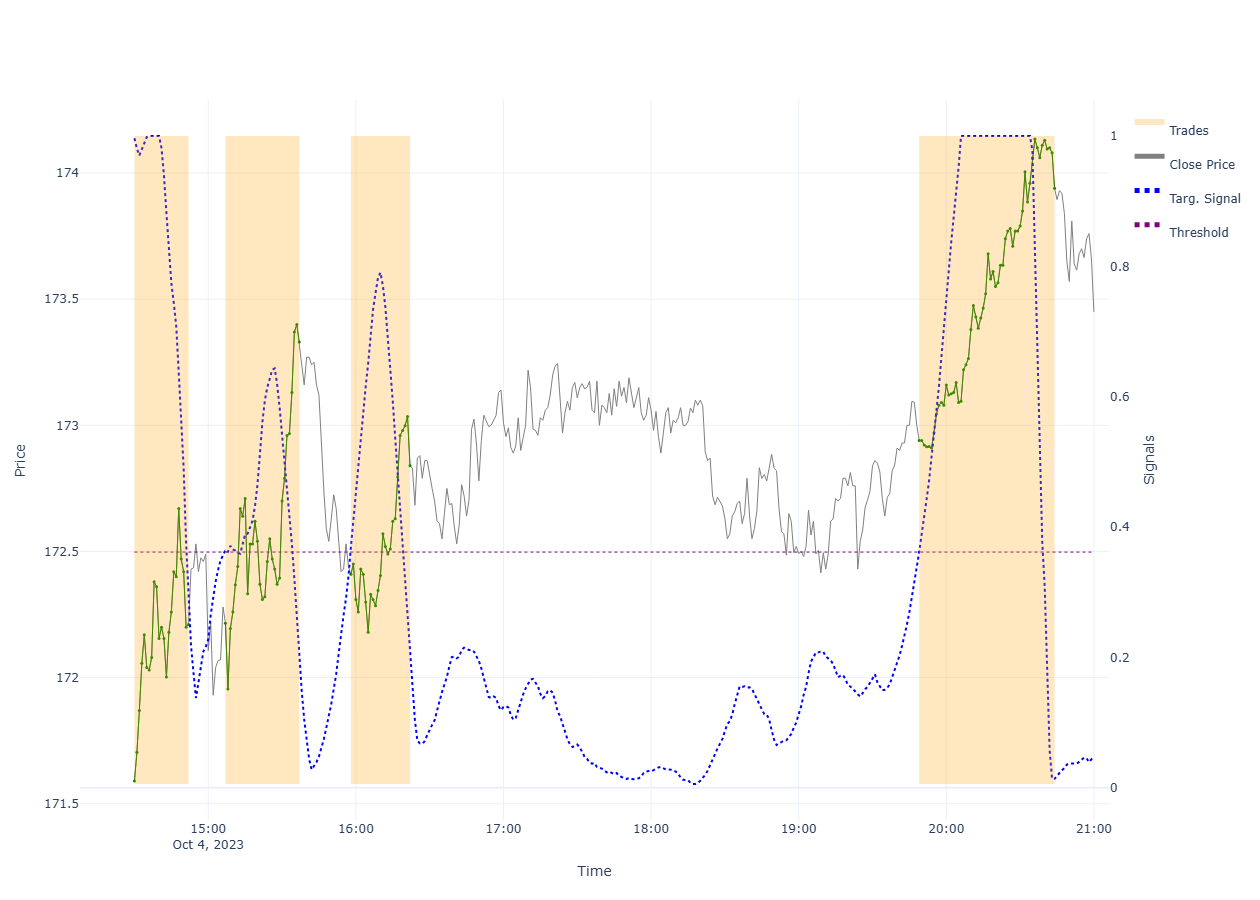

  Buy & Hold Return ($): 1.601
  Strategy Return ($): 2.128
  Trades Returns ($): [0.362, 0.855, 0.171, 0.739]
-------------------------------------------------------------------------------------------------------------------------------------------------


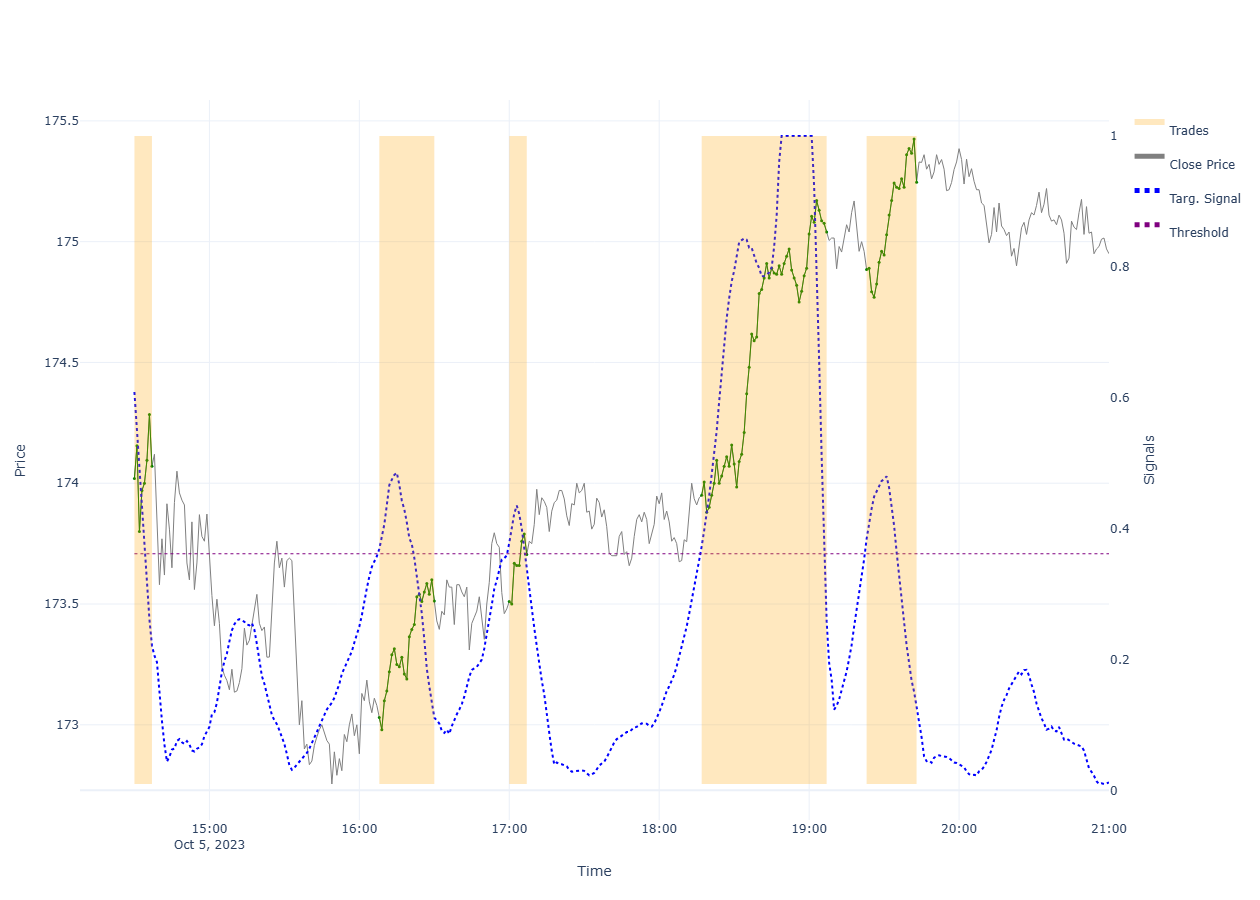

  Buy & Hold Return ($): 0.668
  Strategy Return ($): 0.873
  Trades Returns ($): [-0.211, 0.223, -0.066, 0.829, 0.098]
-------------------------------------------------------------------------------------------------------------------------------------------------


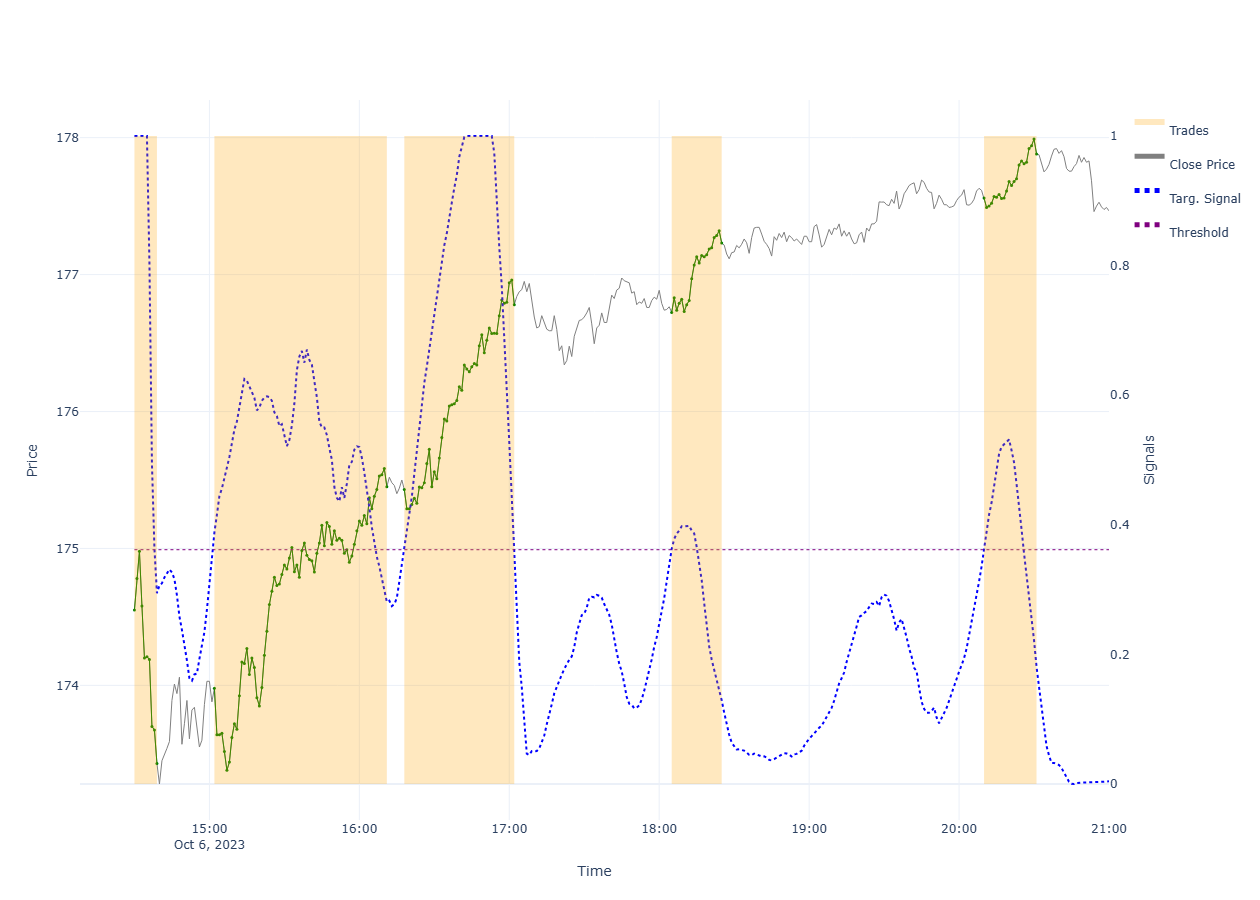

  Buy & Hold Return ($): 2.651
  Strategy Return ($): 1.209
  Trades Returns ($): [-1.382, 1.21, 1.085, 0.241, 0.055]
-------------------------------------------------------------------------------------------------------------------------------------------------


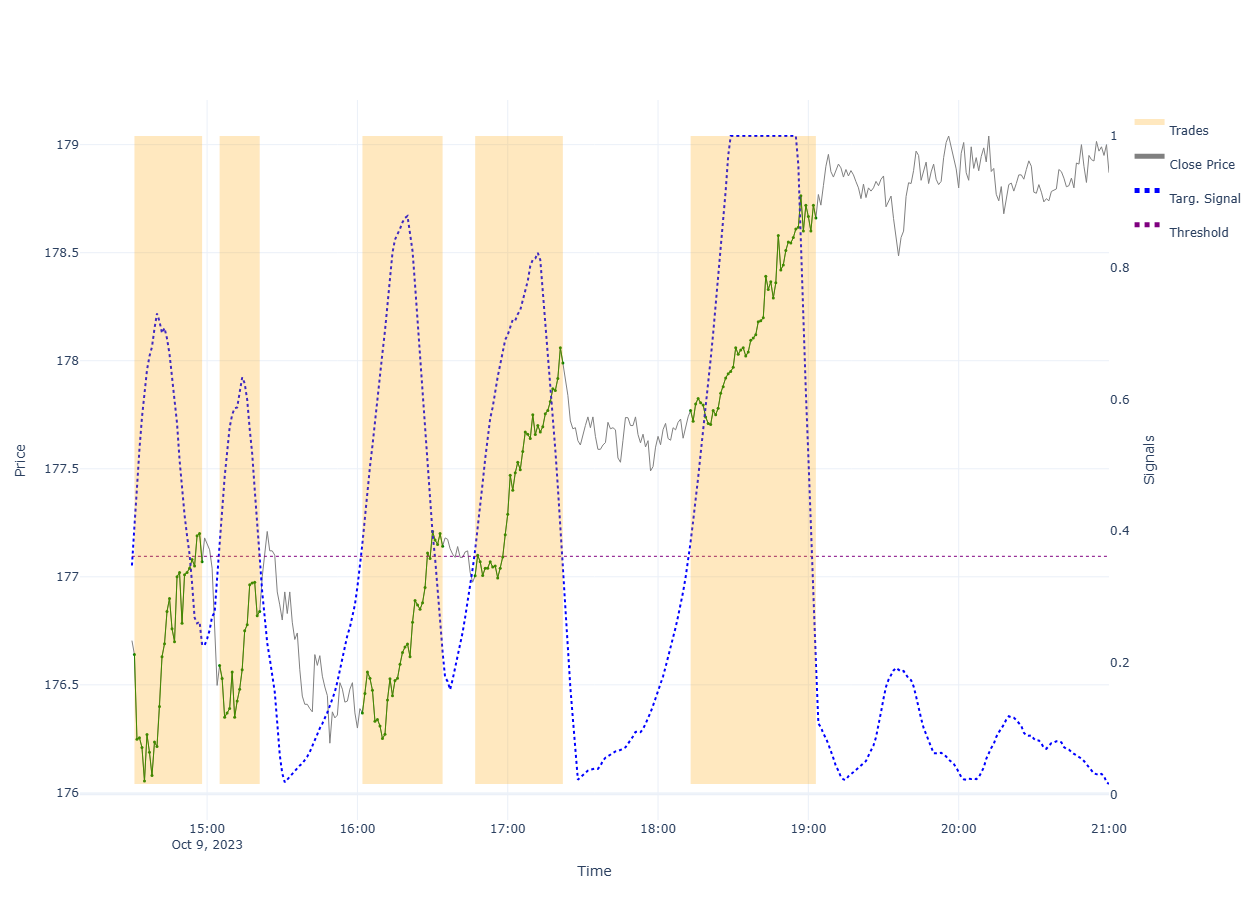

  Buy & Hold Return ($): 1.899
  Strategy Return ($): 1.997
  Trades Returns ($): [0.164, -0.014, 0.507, 0.719, 0.623]
-------------------------------------------------------------------------------------------------------------------------------------------------


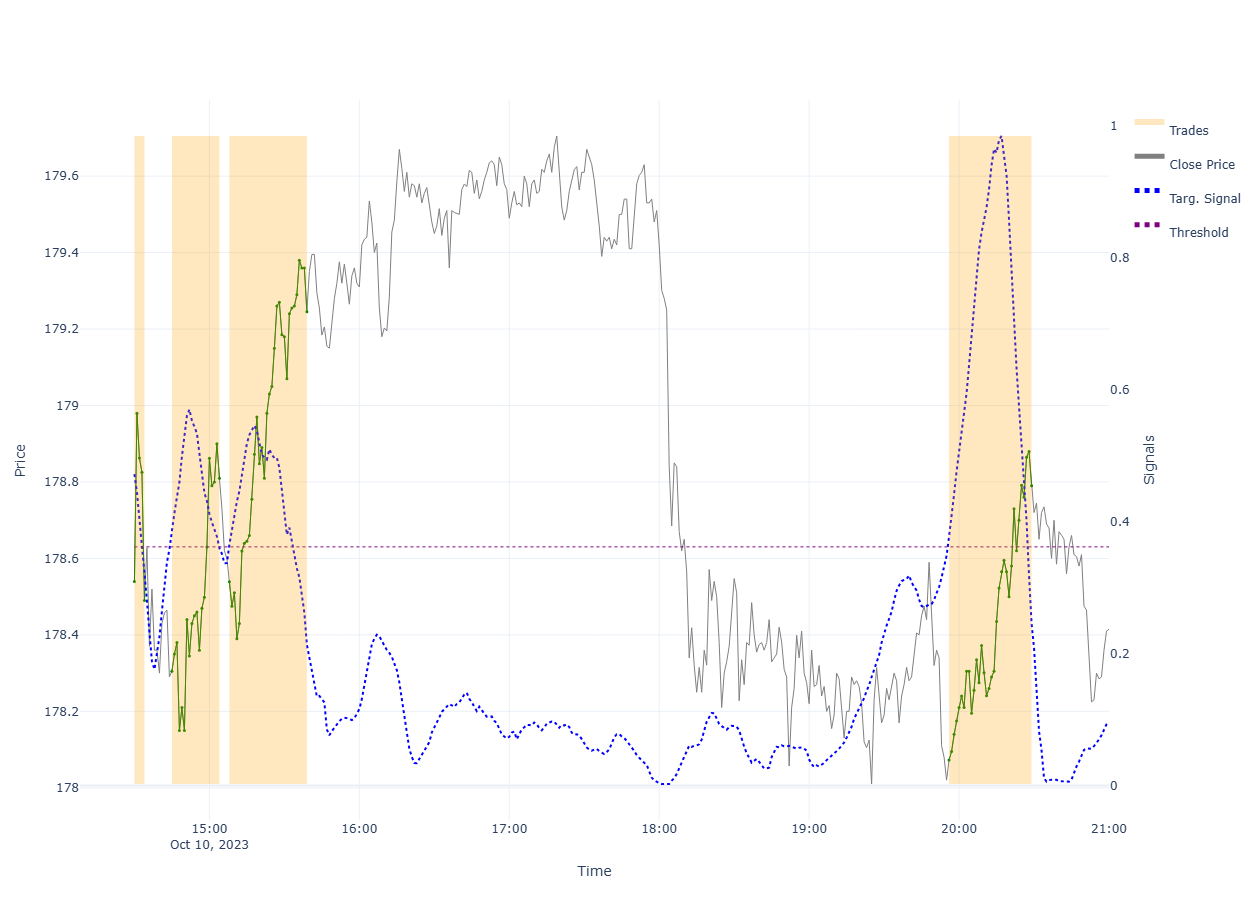

  Buy & Hold Return ($): -0.393
  Strategy Return ($): 0.806
  Trades Returns ($): [-0.318, 0.237, 0.438, 0.449]
-------------------------------------------------------------------------------------------------------------------------------------------------


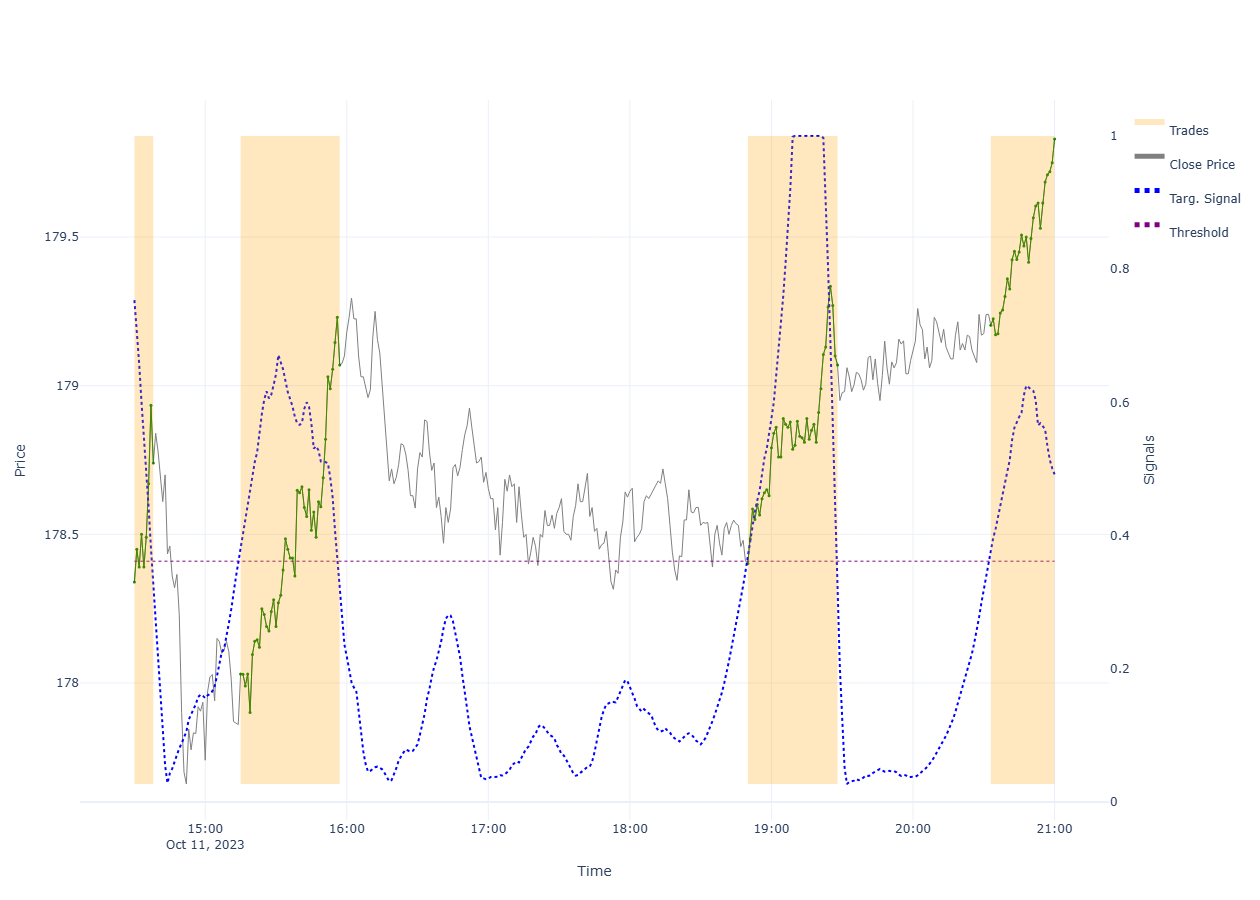

  Buy & Hold Return ($): 1.221
  Strategy Return ($): 1.661
  Trades Returns ($): [0.132, 0.771, 0.4, 0.357]
-------------------------------------------------------------------------------------------------------------------------------------------------


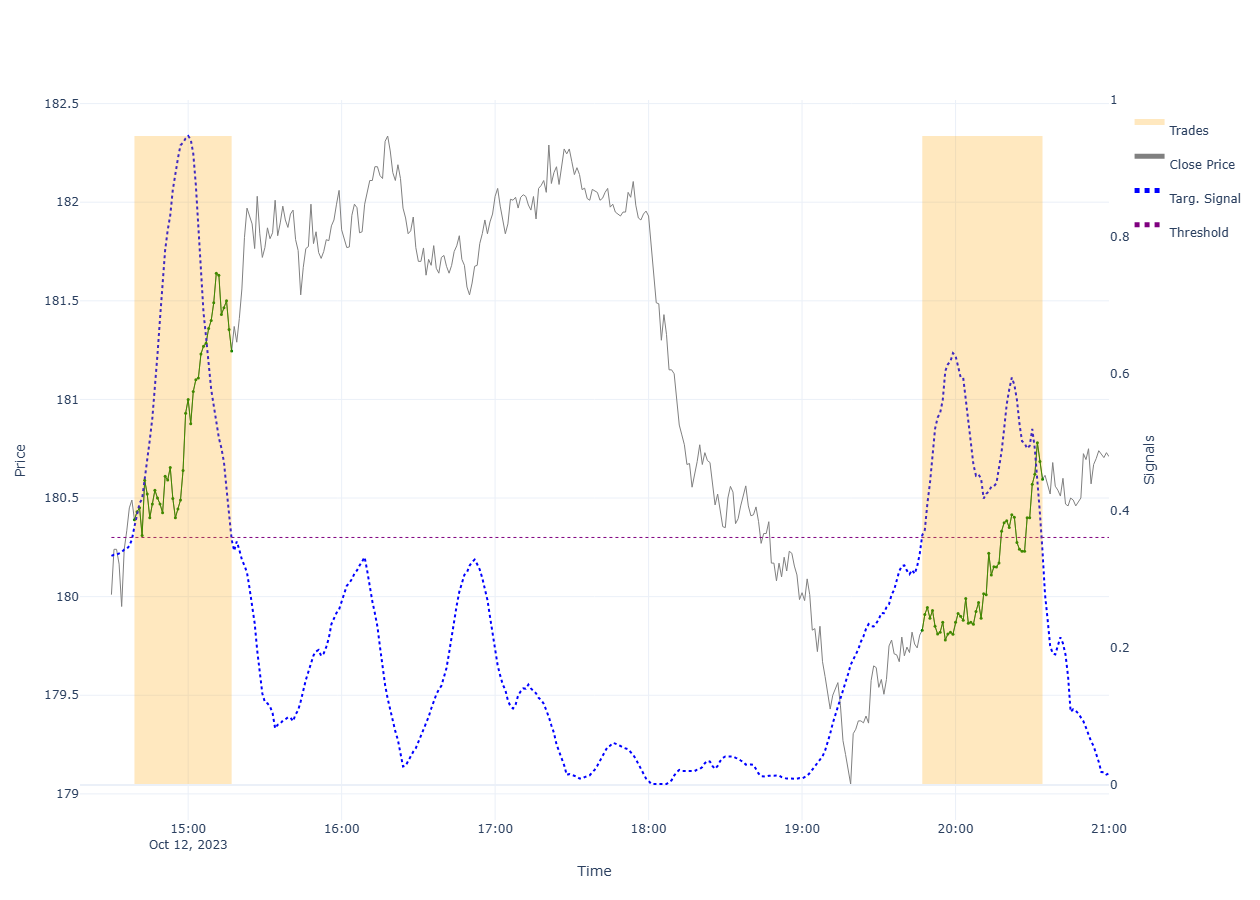

  Buy & Hold Return ($): 0.429
  Strategy Return ($): 1.079
  Trades Returns ($): [0.583, 0.495]
-------------------------------------------------------------------------------------------------------------------------------------------------


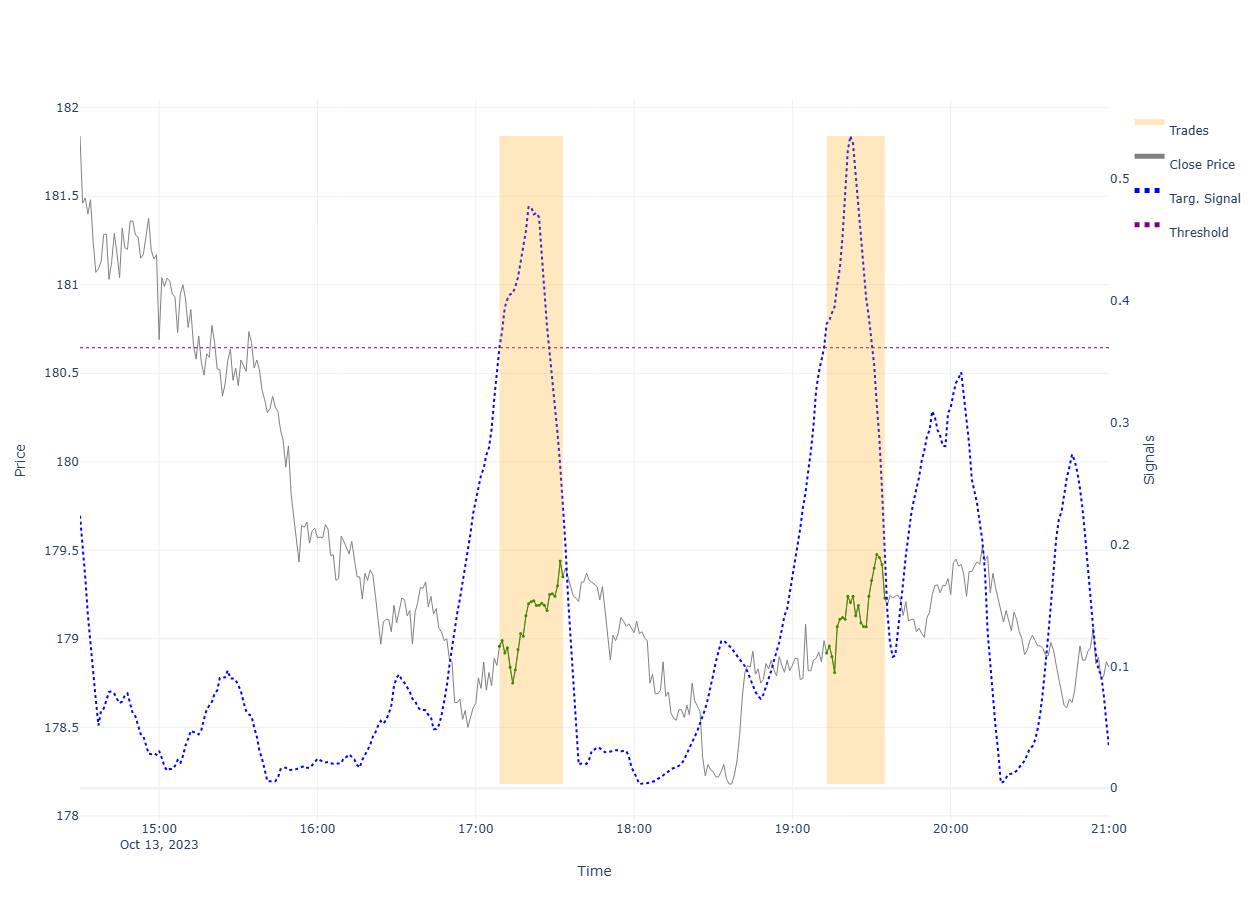

  Buy & Hold Return ($): -3.27
  Strategy Return ($): 0.164
  Trades Returns ($): [0.122, 0.041]
-------------------------------------------------------------------------------------------------------------------------------------------------


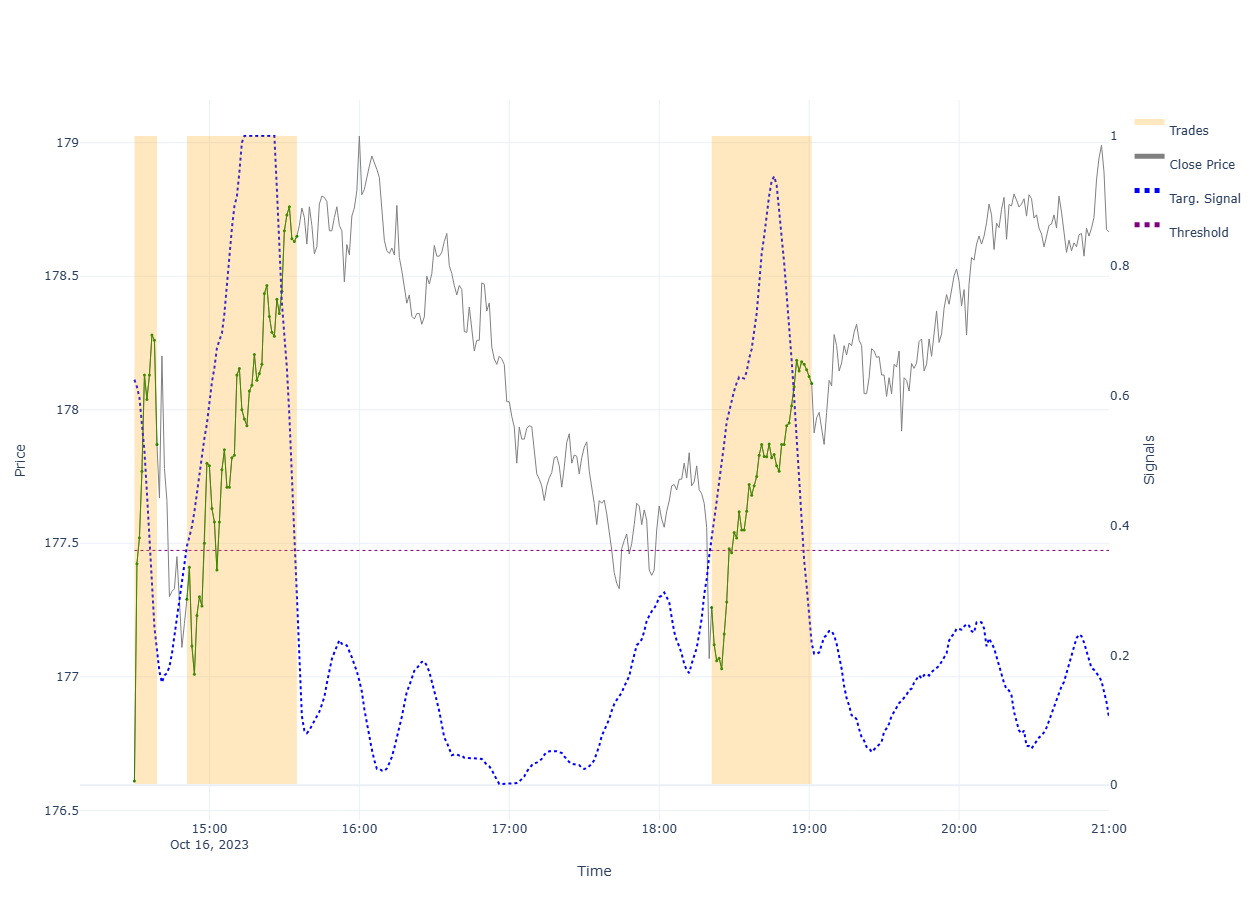

  Buy & Hold Return ($): 1.788
  Strategy Return ($): 2.659
  Trades Returns ($): [0.993, 1.093, 0.573]
-------------------------------------------------------------------------------------------------------------------------------------------------


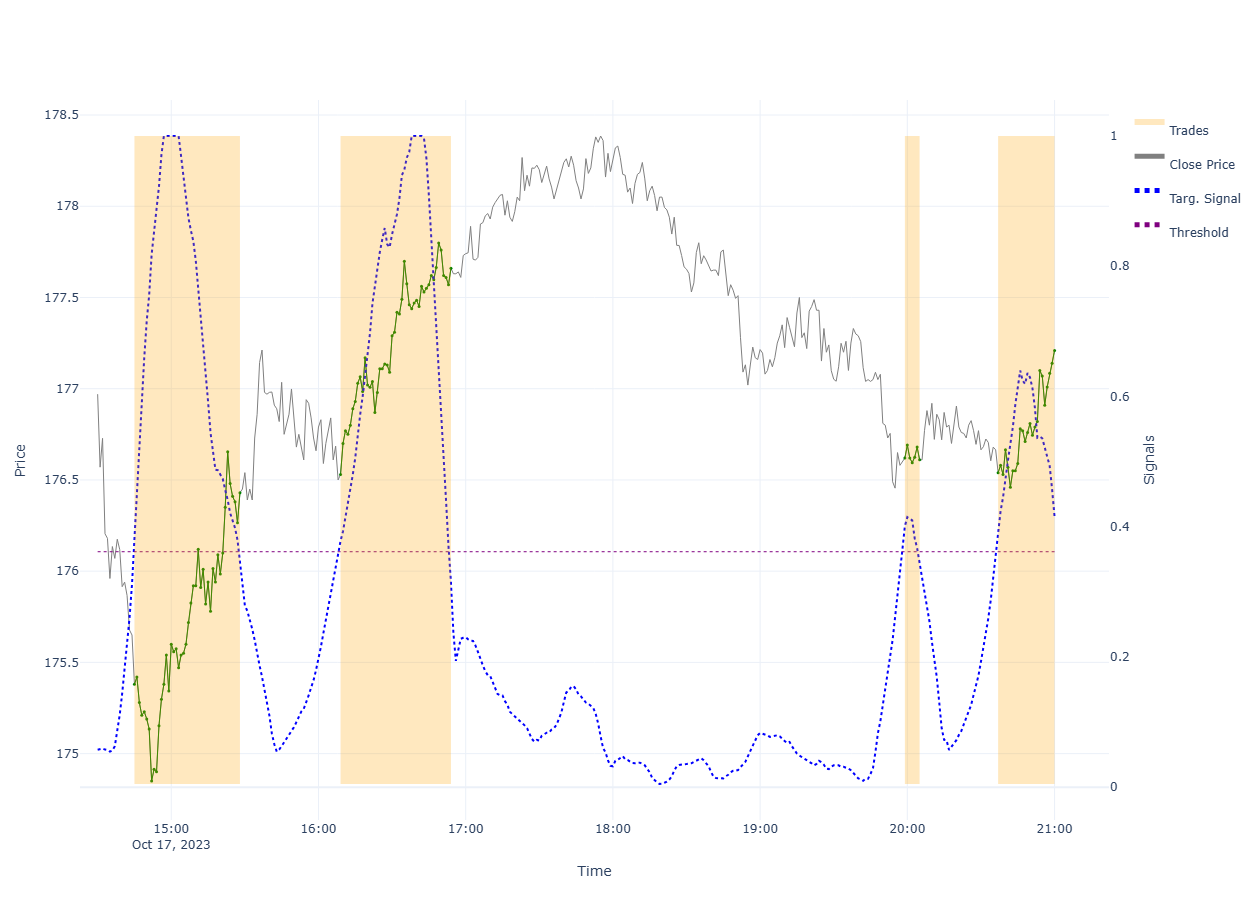

  Buy & Hold Return ($): -0.026
  Strategy Return ($): 1.78
  Trades Returns ($): [0.786, 0.864, -0.276, 0.405]
-------------------------------------------------------------------------------------------------------------------------------------------------


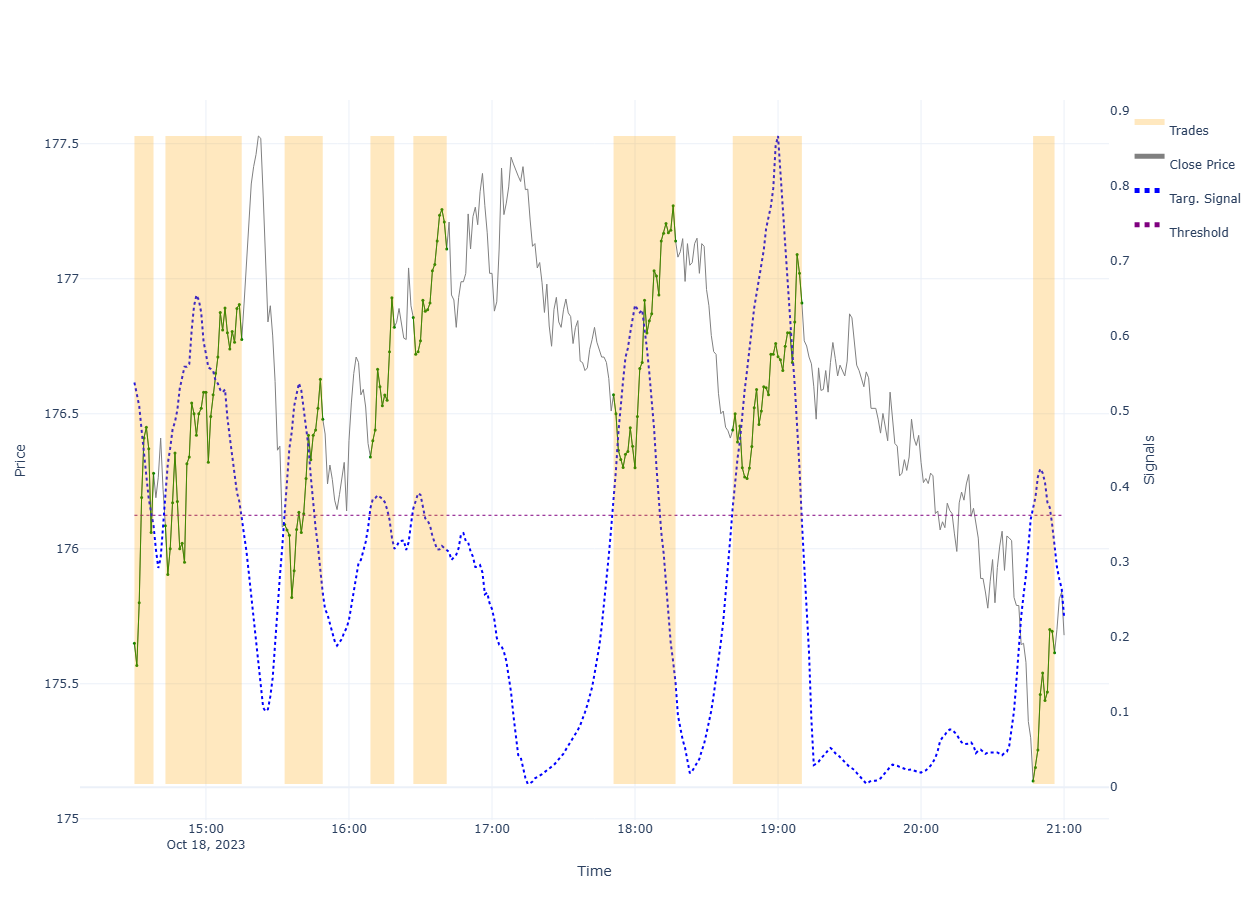

  Buy & Hold Return ($): -0.233
  Strategy Return ($): 1.842
  Trades Returns ($): [0.366, 0.425, 0.125, 0.215, -0.011, 0.304, 0.205, 0.212]
-------------------------------------------------------------------------------------------------------------------------------------------------


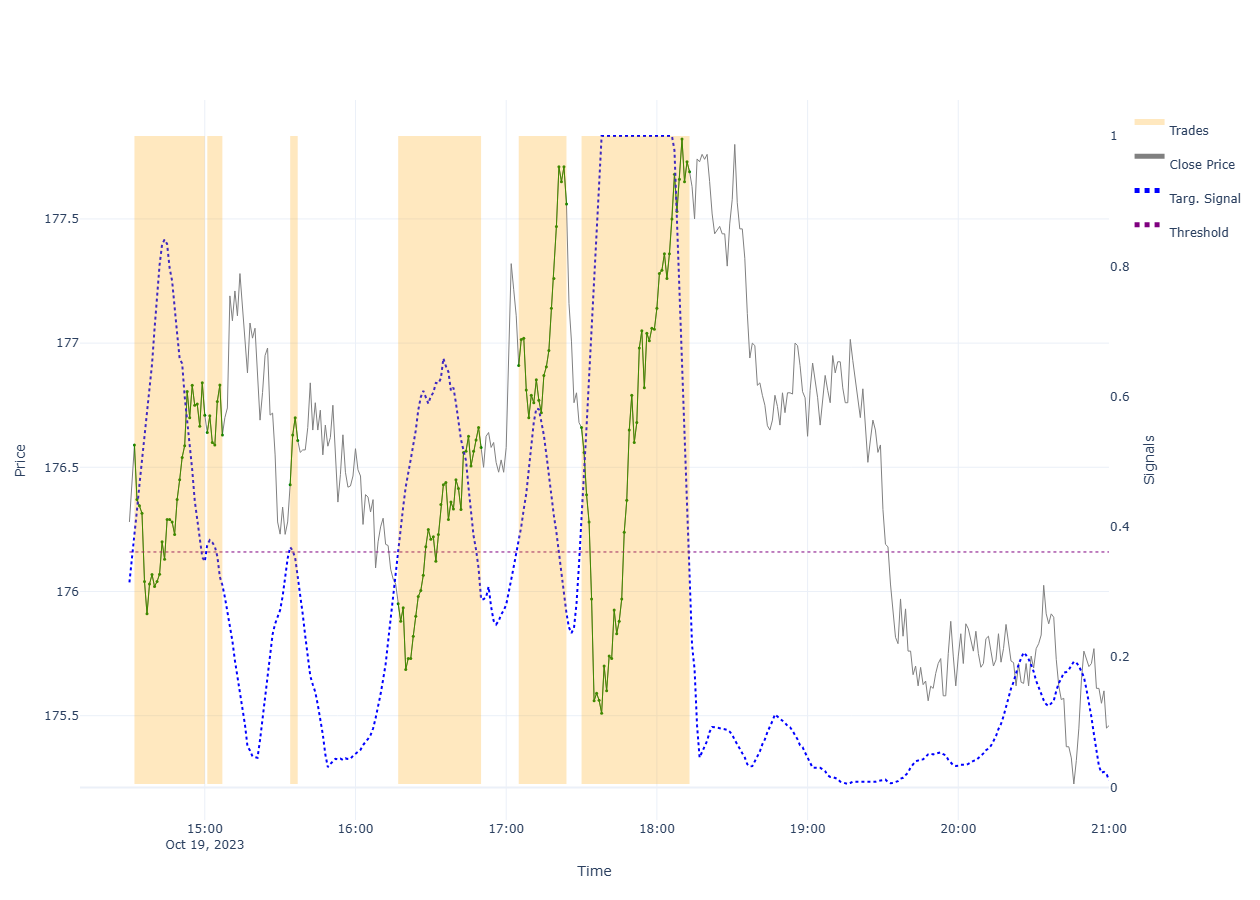

  Buy & Hold Return ($): -1.084
  Strategy Return ($): 1.007
  Trades Returns ($): [-0.145, -0.276, -0.087, 0.364, 0.384, 0.764]
-------------------------------------------------------------------------------------------------------------------------------------------------


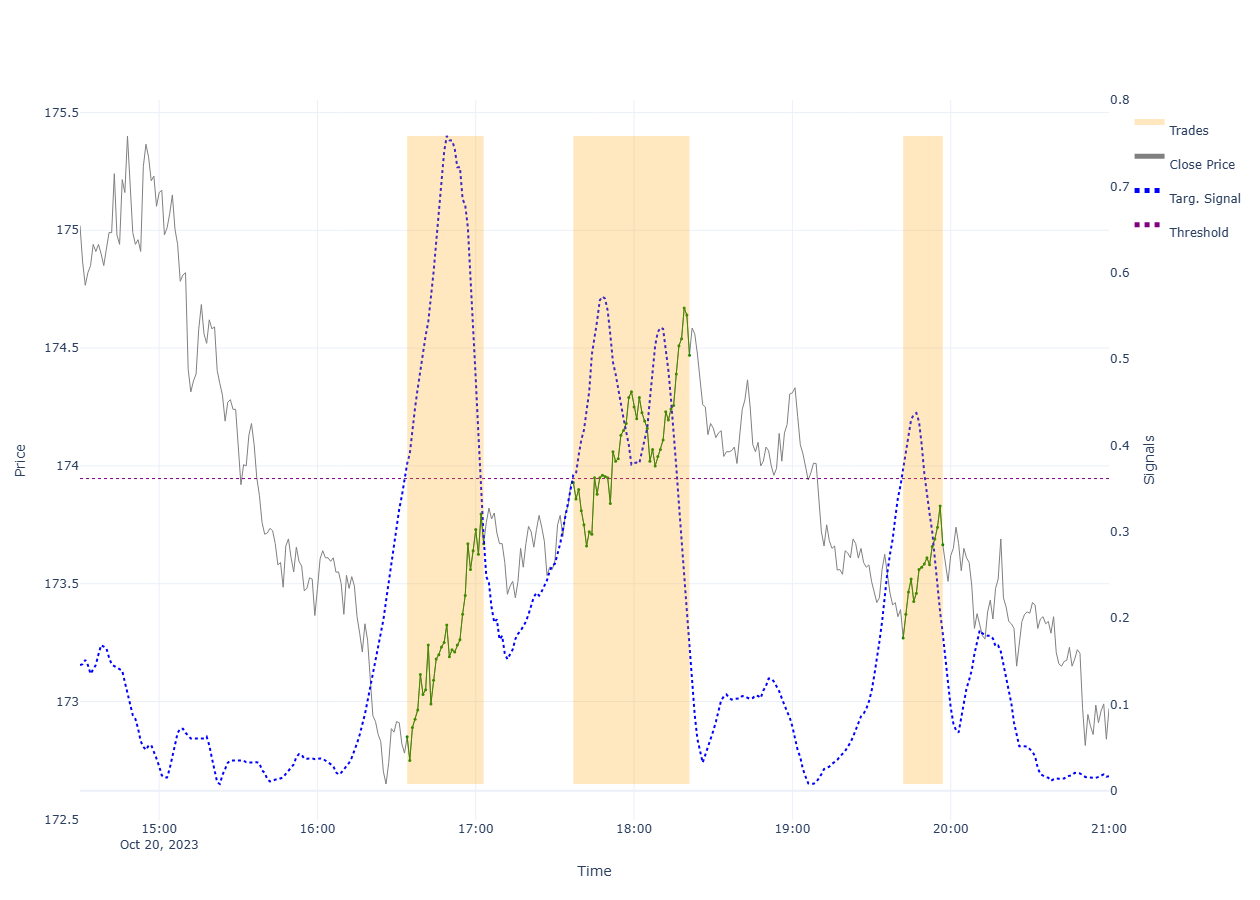

  Buy & Hold Return ($): -2.311
  Strategy Return ($): 0.974
  Trades Returns ($): [0.56, 0.278, 0.135]
-------------------------------------------------------------------------------------------------------------------------------------------------


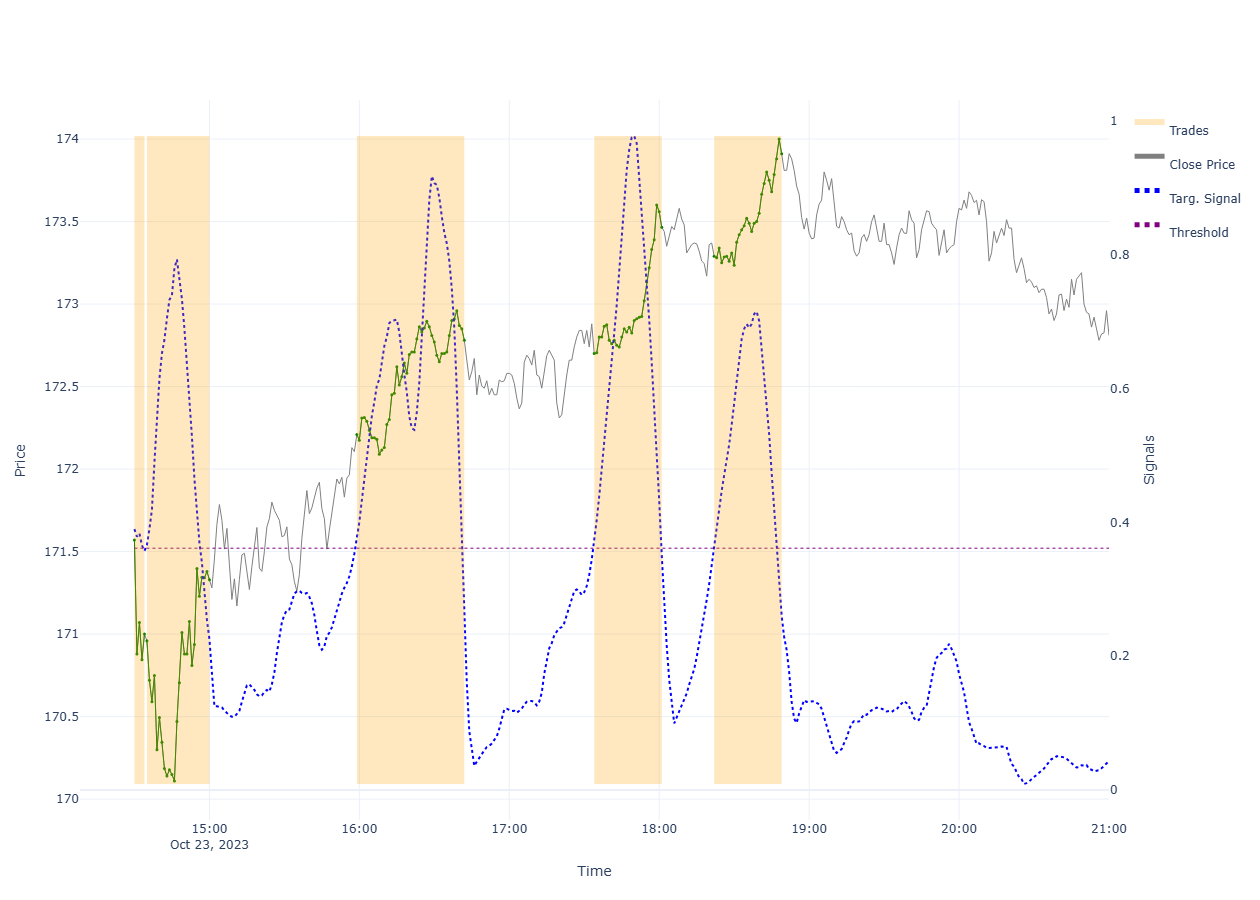

  Buy & Hold Return ($): 0.982
  Strategy Return ($): 0.463
  Trades Returns ($): [-0.828, 0.113, 0.312, 0.505, 0.359]
-------------------------------------------------------------------------------------------------------------------------------------------------


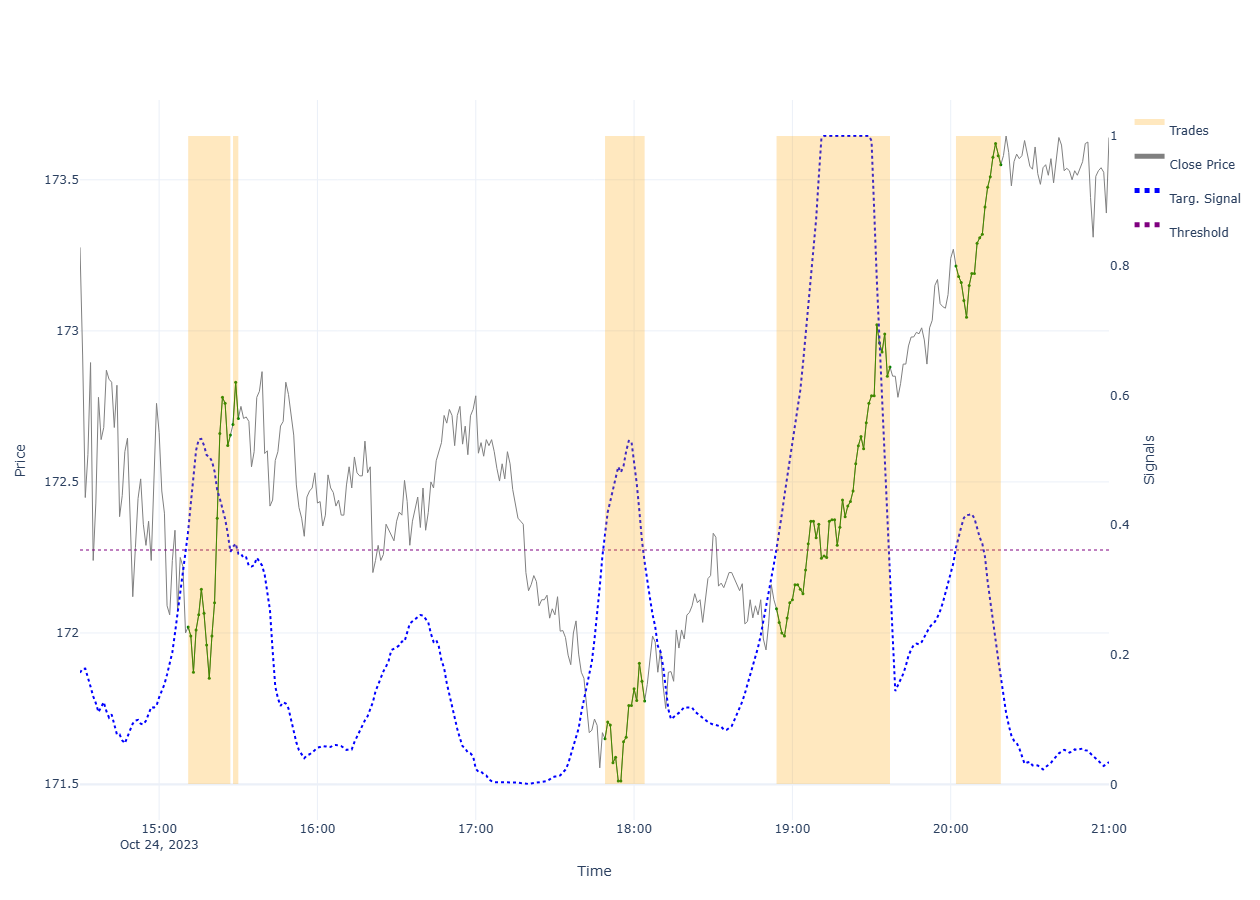

  Buy & Hold Return ($): 0.104
  Strategy Return ($): 0.621
  Trades Returns ($): [0.377, -0.238, -0.132, 0.541, 0.075]
-------------------------------------------------------------------------------------------------------------------------------------------------


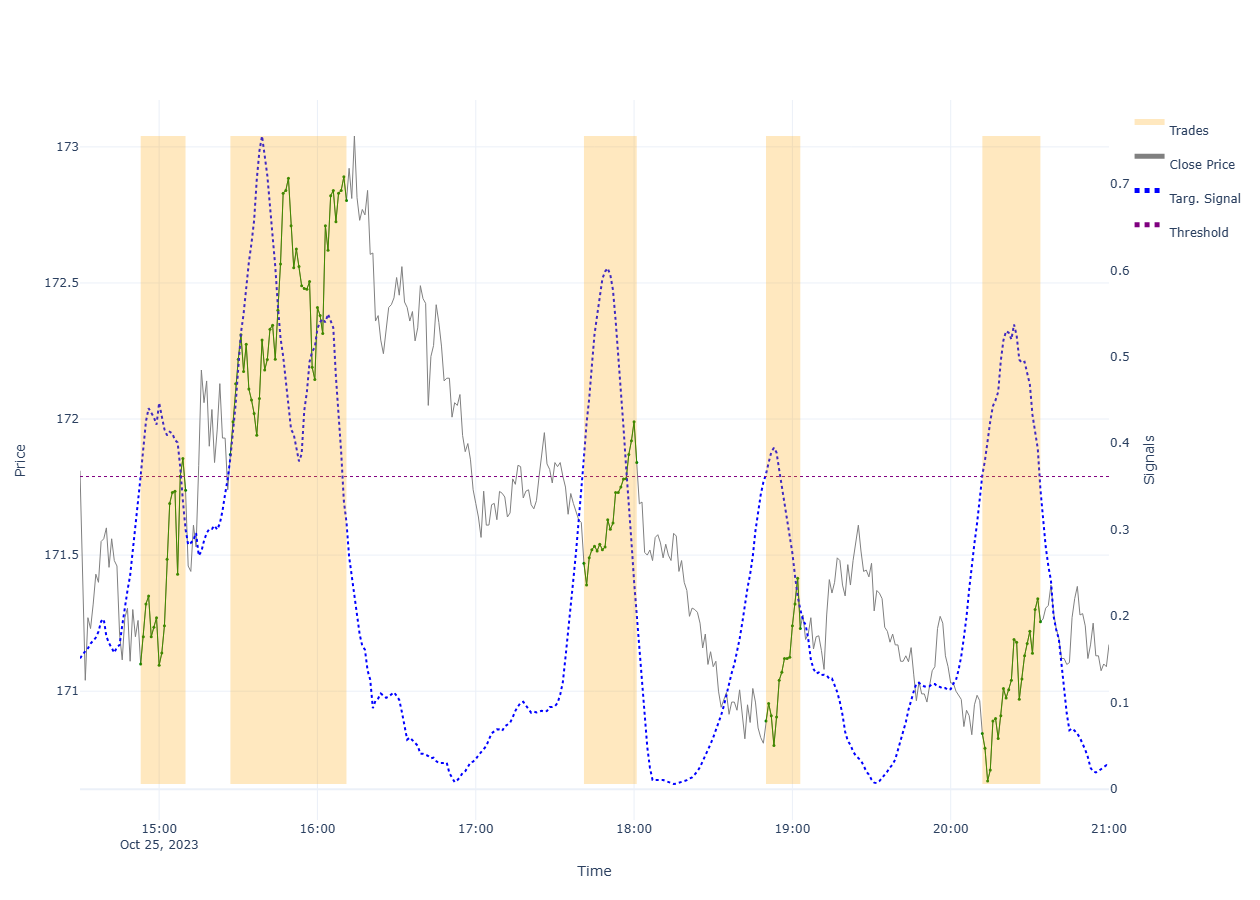

  Buy & Hold Return ($): -0.896
  Strategy Return ($): 1.406
  Trades Returns ($): [0.382, 0.674, 0.113, 0.084, 0.154]
-------------------------------------------------------------------------------------------------------------------------------------------------


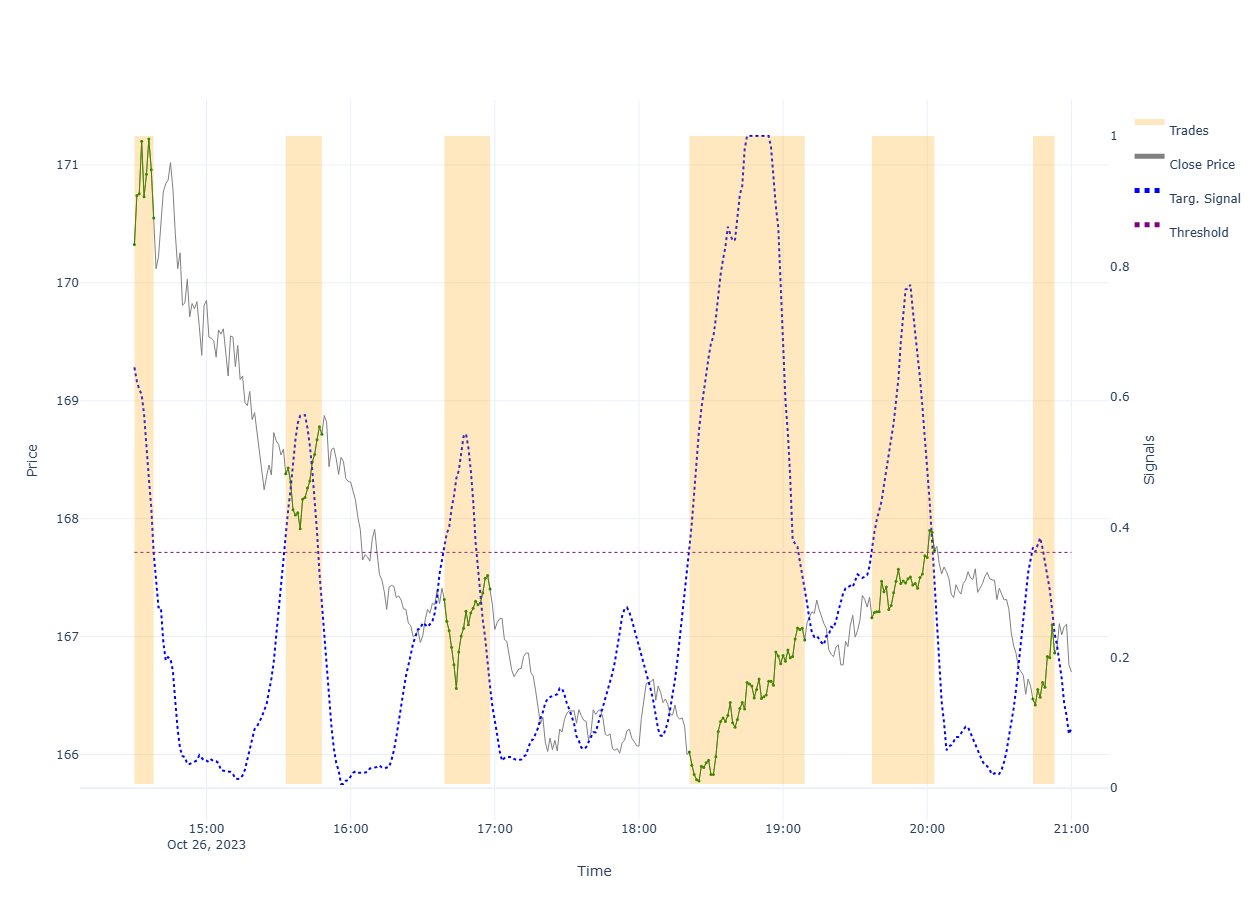

  Buy & Hold Return ($): -3.878
  Strategy Return ($): 1.048
  Trades Returns ($): [-0.031, 0.083, -0.162, 0.701, 0.32, 0.14]
-------------------------------------------------------------------------------------------------------------------------------------------------


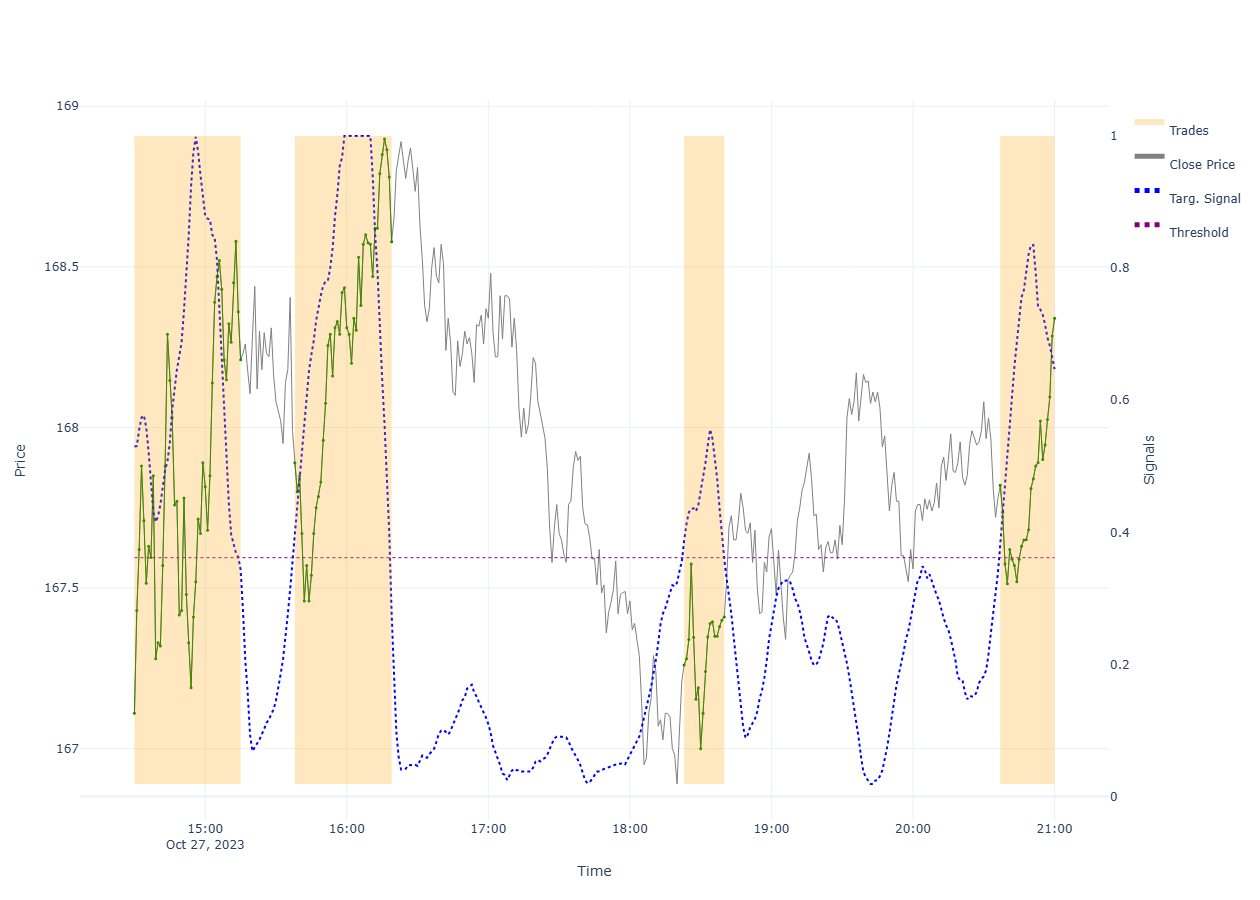

  Buy & Hold Return ($): 0.978
  Strategy Return ($): 1.452
  Trades Returns ($): [0.85, 0.437, -0.1, 0.267]
-------------------------------------------------------------------------------------------------------------------------------------------------


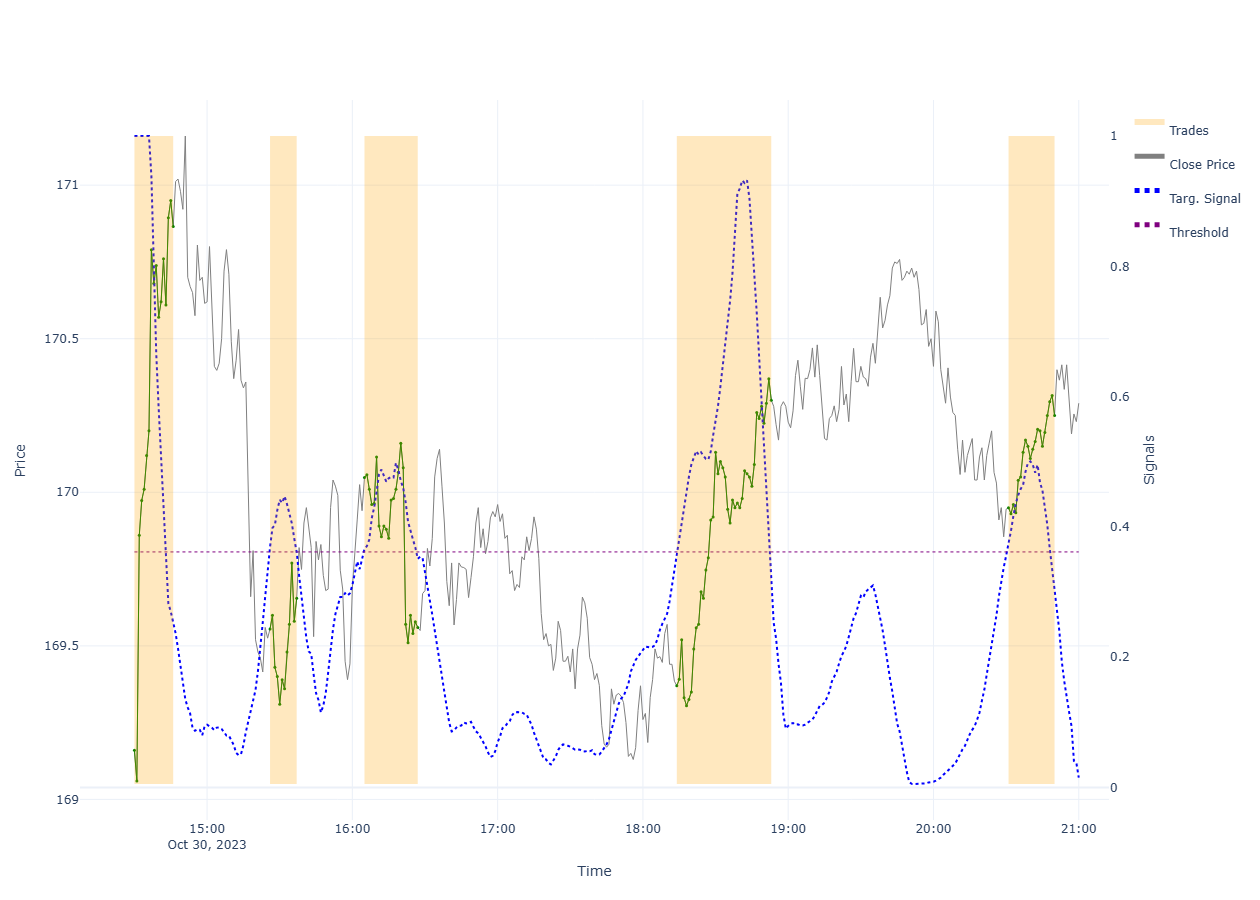

  Buy & Hold Return ($): 0.875
  Strategy Return ($): 1.273
  Trades Returns ($): [1.451, -0.154, -0.742, 0.675, 0.044]
-------------------------------------------------------------------------------------------------------------------------------------------------


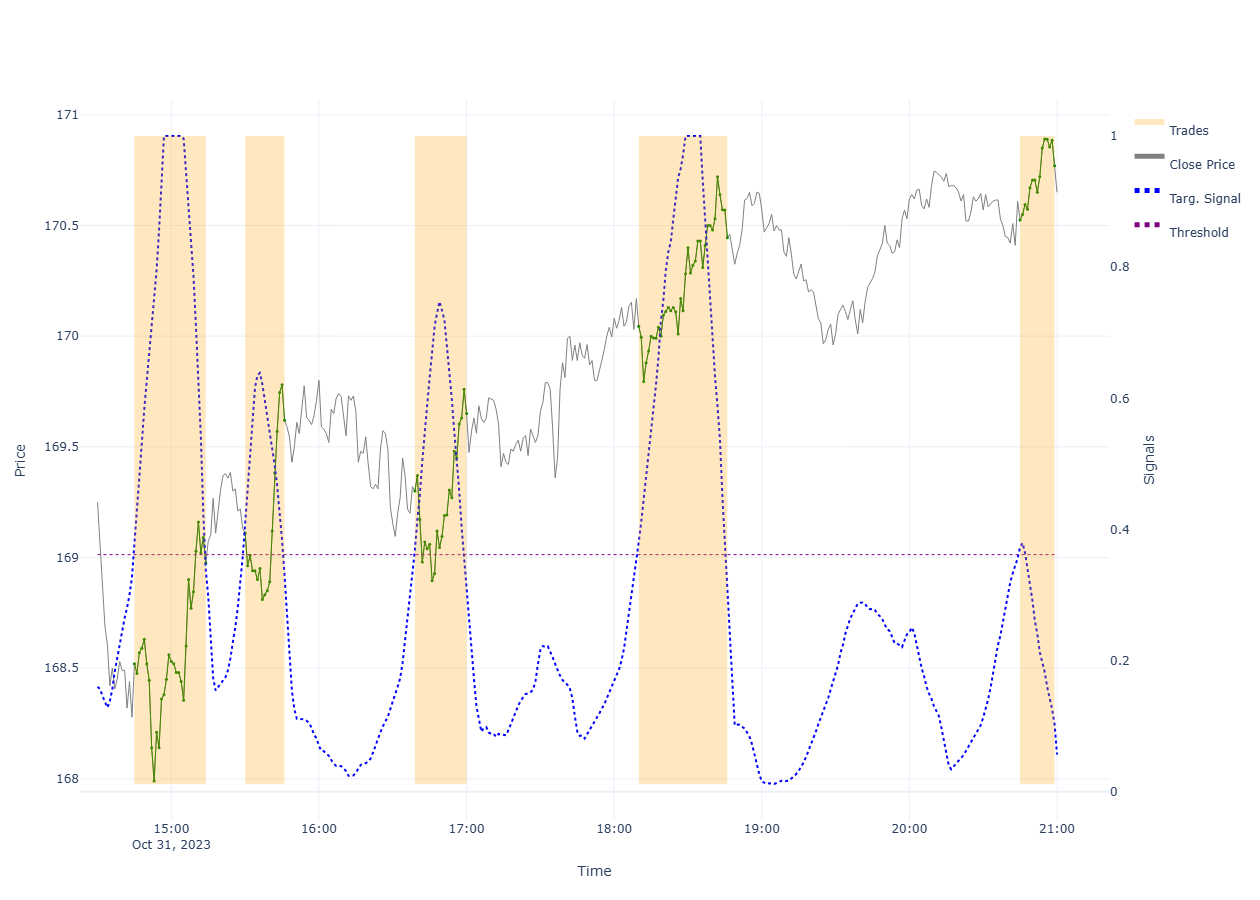

  Buy & Hold Return ($): 1.145
  Strategy Return ($): 0.687
  Trades Returns ($): [0.202, 0.256, 0.095, 0.145, -0.01]

Overall Summary (2023-10-02 = 171.2383 → 2023-10-31 = 170.5220)

One-time buy&hold gain: -0.716
Buy & Hold – each day ($): 4.182
Strategy Return ($): 28.679
Trades Count: 101
Strategy return per trade: 0.284
Num. trading days: 22
Strategy return per trading day: 1.304


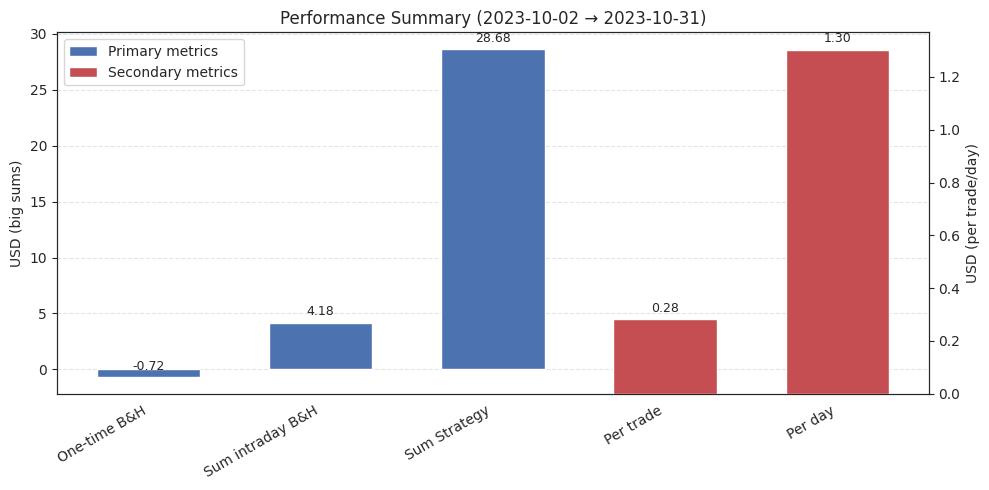


******************** Running pipeline on full dataset ********************
Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.868 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.23day/s]



Overall Summary (2004-01-02 = 0.7731 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 195.620
Buy & Hold – each day ($): -385.278
Strategy Return ($): 2778.954
Trades Count: 22753
Strategy return per trade: 0.122
Num. trading days: 5400
Strategy return per trading day: 0.515


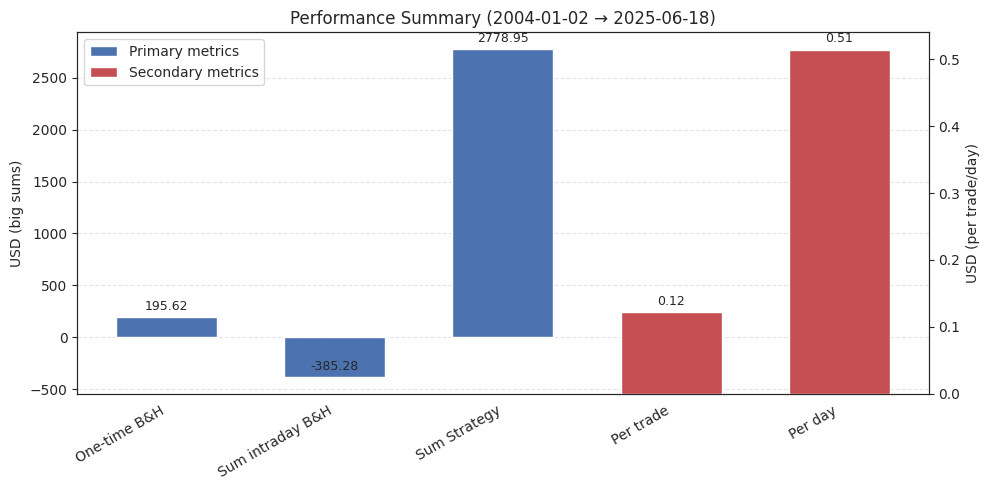


Overall Summary (2022-03-28 = 172.8295 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 23.563
Buy & Hold – each day ($): -189.487
Strategy Return ($): 1375.550
Trades Count: 3428
Strategy return per trade: 0.401
Num. trading days: 810
Strategy return per trading day: 1.698


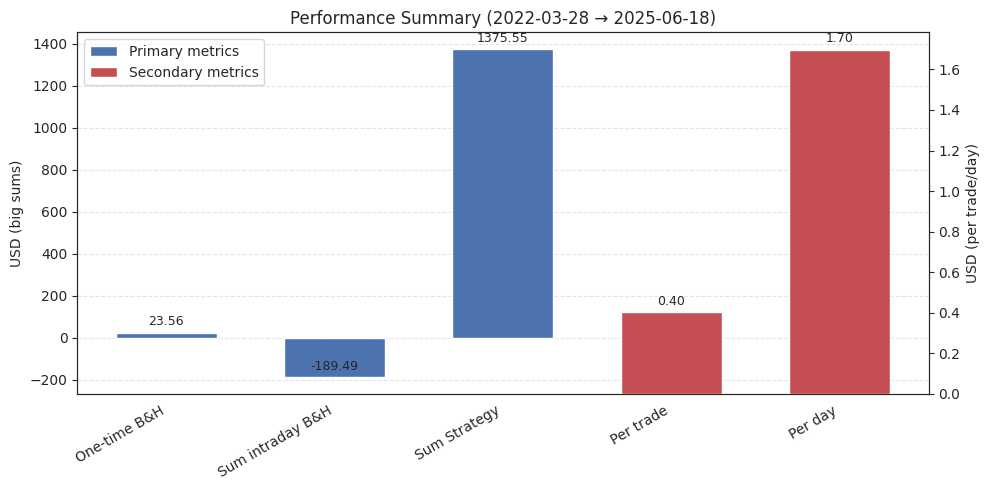


Saving full-run signals to dfs/AAPL_2_sign.csv …
CSV saved.


open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid    signal_raw  \
2004-01-02 09:00:00     28000.0    0.764857    0.763714  1.333463e-14   
2004-01-02 09:01:00     28000.0    0.764857    0.763714  1.440085e-14   
2004-01-02 09:02:00     28000.0    0.764857    0.763714  1.555233e-14   
2004-01-02 09:03:00     28000.0    0.764857    0.763714  1.679588e-14   
2004-01-02 09:04:00     28000.0    0.764857    0.763714  1.813886e-14   
...                         ...         ...         ...           ...   
2025-06-18 20:56:00    385695.0  196.962600  196.667400  0.000000e+00   
2025-06-18 20:57:00    460630.0  196.822500  196.527500  0.000000e+00   
2025-06-18 20:58:00    525245.0  196.817500  196.522500  0.000000e+00   
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  6.911445e-06   
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  0.000000e+00   

                           signal  signal_action  Position     Cash  NetValue  \
2004-01-02 09:00:00  1.293905e-10              0         0    0.000     0.000   
2004-01-02 09:01:00  1.350248e-10              0         0    0.000     0.000   
2004-01-02 09:02:00  1.409723e-10              0         0    0.000     0.000   
2004-01-02 09:03:00  1.472522e-10              0         0    0.000     0.000   
2004-01-02 09:04:00  1.538851e-10              0         0    0.000     0.000   
...                           ...            ...       ...      ...       ...   
2025-06-18 20:56:00  6.849078e-01              0         1 -193.687     2.981   
2025-06-18 20:57:00  6.122057e-01              0         1 -193.687     2.841   
2025-06-18 20:58:00  6.104678e-01              0         1 -193.687     2.836   
2025-06-18 20:59:00  4.770902e-01              0         1 -193.687     2.406   
2025-06-18 21:00:00  3.509684e-01             -1         1 -193.687     2.706   

                       Action  TradedAmount  BuyHoldEarning  StrategyEarning  \
2004-01-02 09:00:00  No trade             0           0.000            0.000   
2004-01-02 09:01:00  No trade             0           0.000            0.000   
2004-01-02 09:02:00  No trade             0           0.000            0.000   
2004-01-02 09:03:00  No trade             0           0.000            0.000   
2004-01-02 09:04:00  No trade             0           0.000            0.000   
...                       ...           ...             ...              ...   
2025-06-18 20:56:00      Hold             0           0.600            2.981   
2025-06-18 20:57:00      Hold             0           0.461            2.841   
2025-06-18 20:58:00      Hold             0           0.456            2.836   
2025-06-18 20:59:00      Hold             0           0.026            2.406   
2025-06-18 21:00:00  No trade             0           0.326            2.706   

                     EarningDiff  
2004-01-02 09:00:00        0.000  
2004-01-02 09:01:00        0.000  
2004-01-02 09:02:00        0.000  
2004-01-02 09:03:00        0.000  
2004-01-02 09:04:00        0.000  
...                          ...  
2025-06-18 20:56:00        2.381  
2025-06-18 20:57:00        2.380  
2025-06-18 20:58:00        2.380  
2025-06-18 20

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

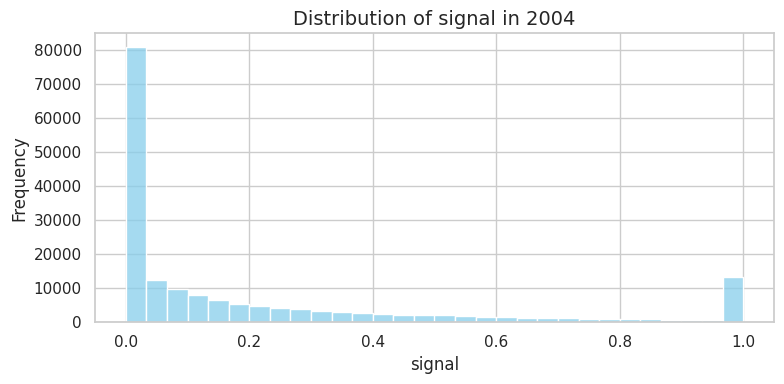

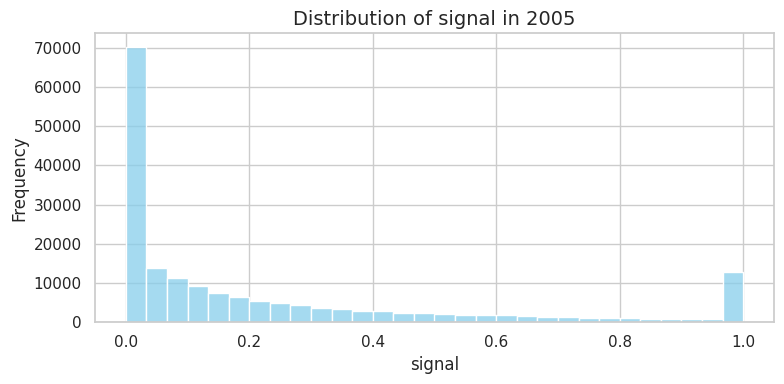

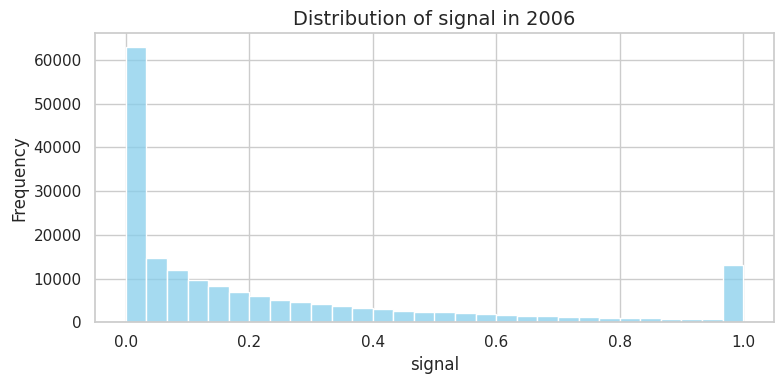

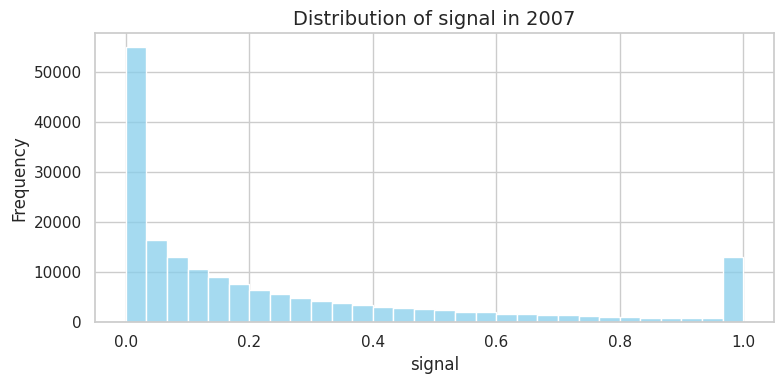

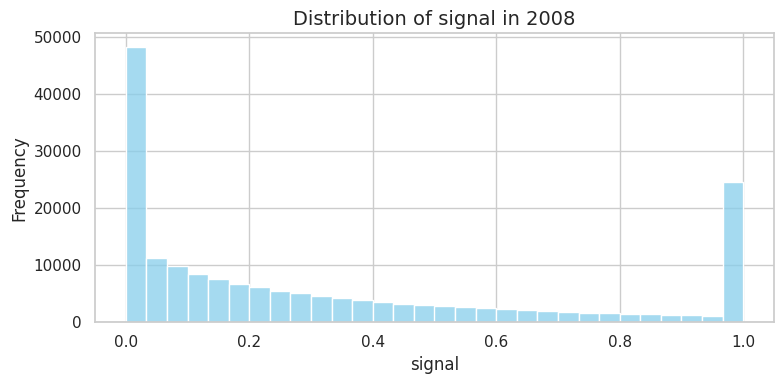

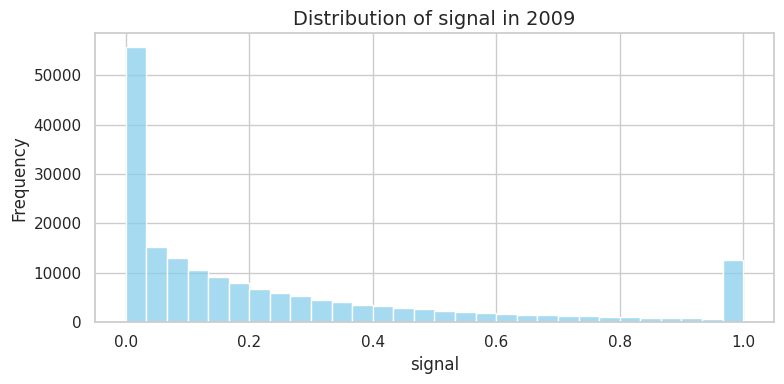

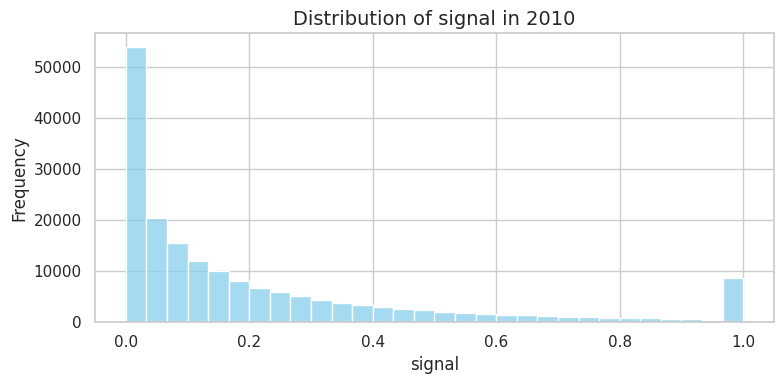

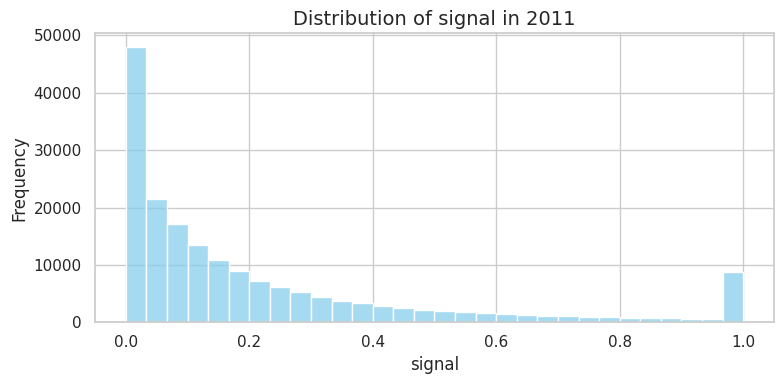

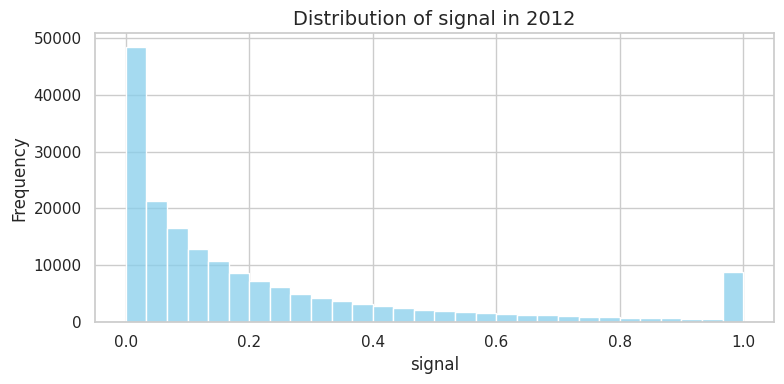

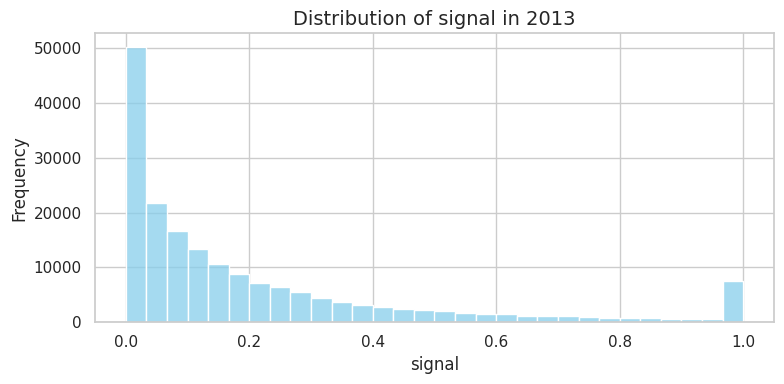

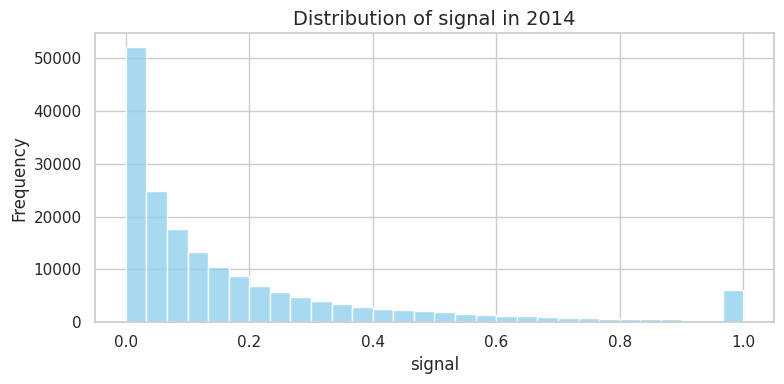

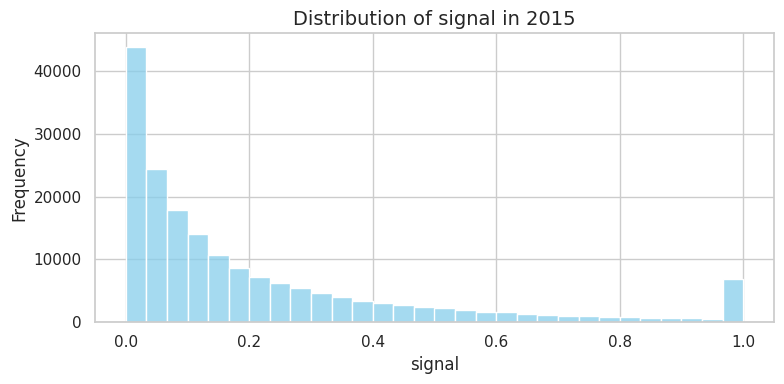

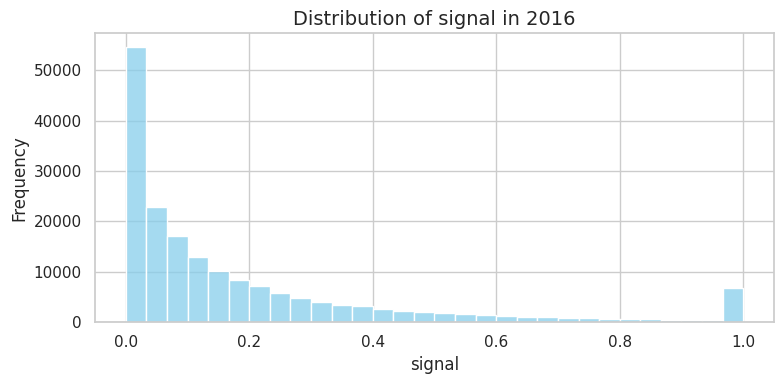

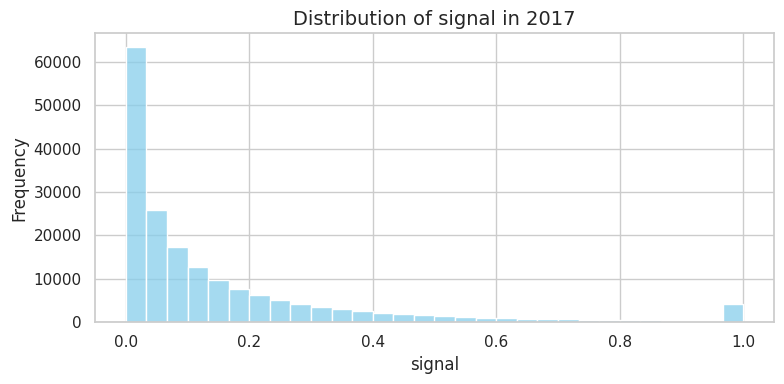

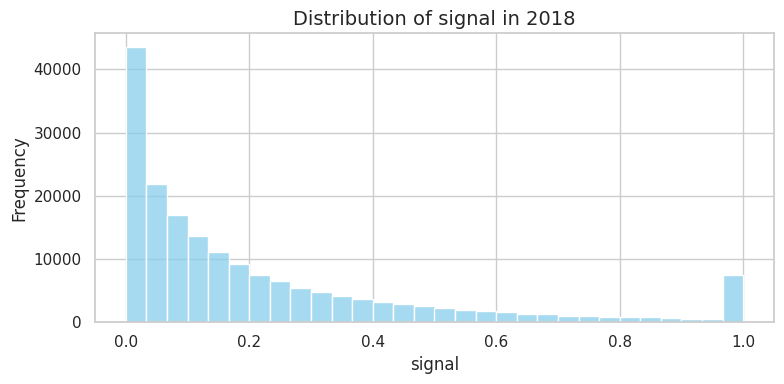

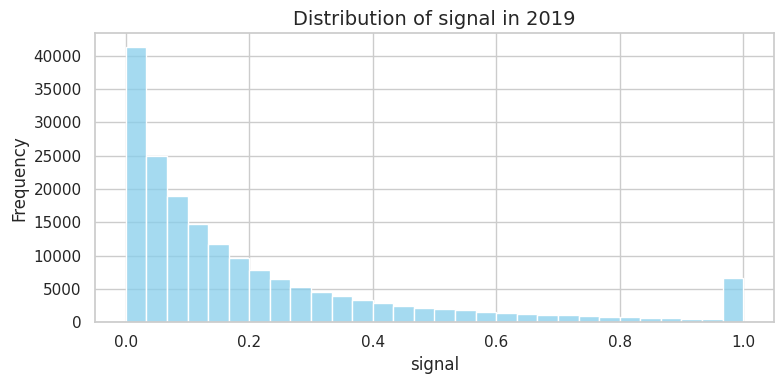

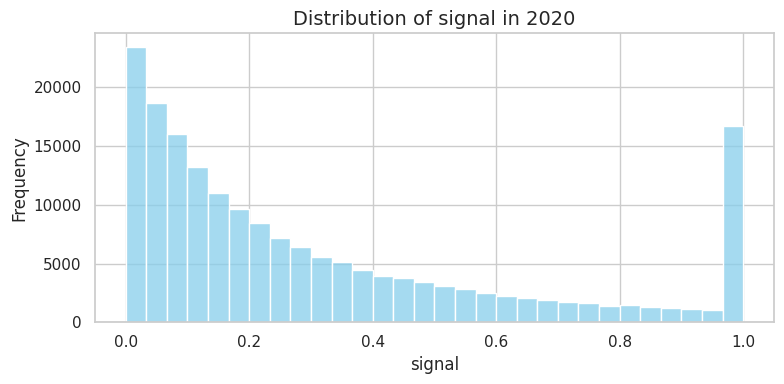

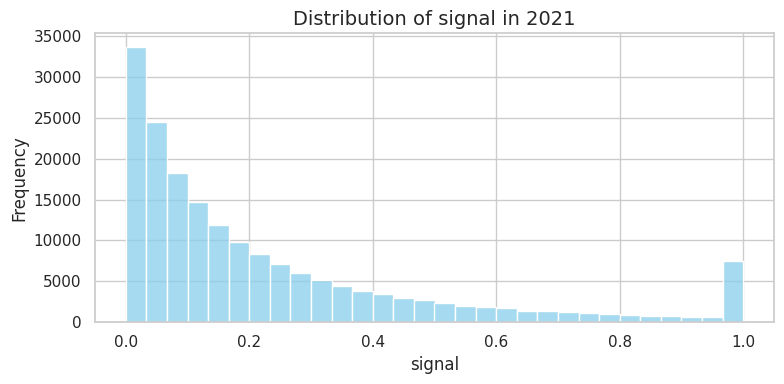

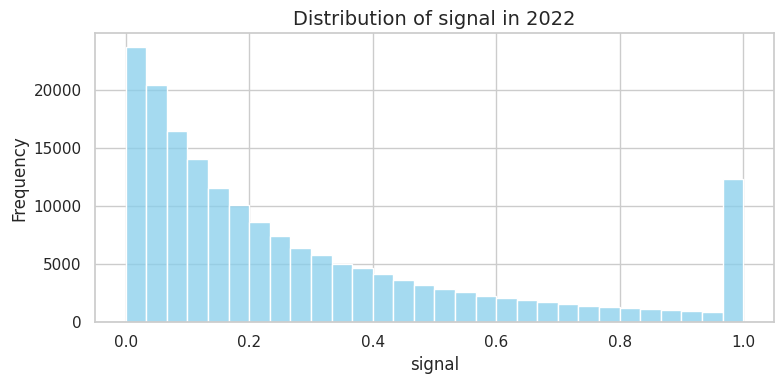

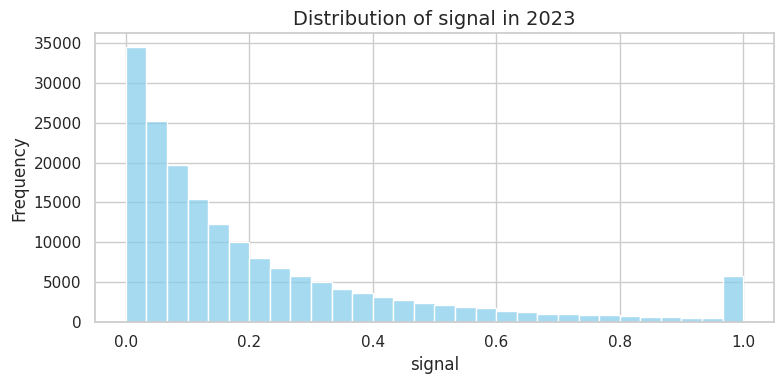

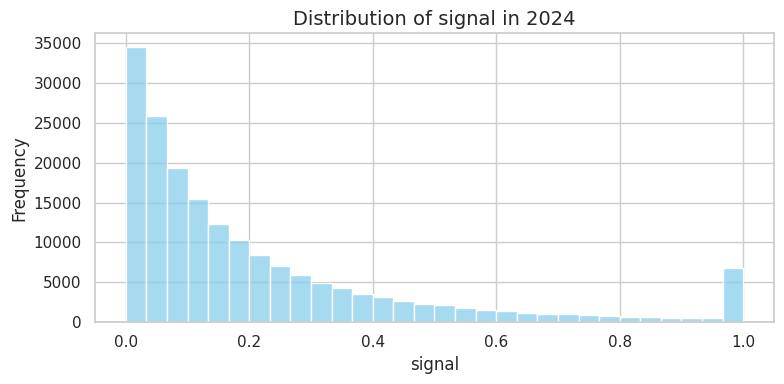

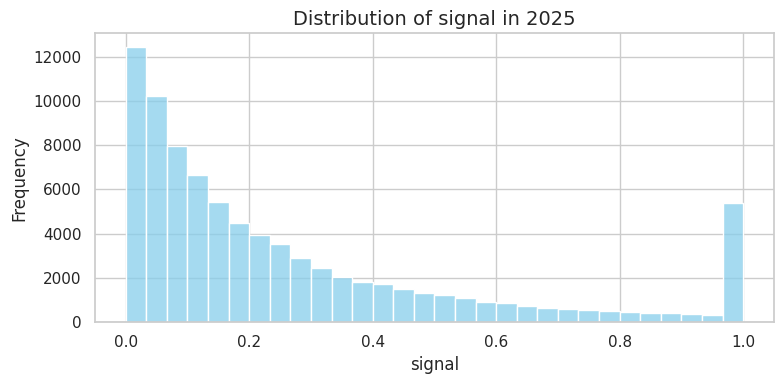

signal_min  signal_max  signal_mean  signal_median  close_return
2004-01  0.000000e+00         1.0     0.212535       0.066127      0.170916
2004-02  0.000000e+00         1.0     0.180837       0.040486      0.105893
2004-03  0.000000e+00         1.0     0.220490       0.065335      0.196335
2004-04  0.000000e+00         1.0     0.202531       0.047551      0.156863
2004-05  0.000000e+00         1.0     0.209172       0.049637      0.127743
2004-06  0.000000e+00         1.0     0.221597       0.055643      0.241579
2004-07  0.000000e+00         1.0     0.221625       0.059922      0.161862
2004-08  0.000000e+00         1.0     0.213317       0.041510      0.182185
2004-09  0.000000e+00         1.0     0.208675       0.052602      0.145439
2004-10  0.000000e+00         1.0     0.224766       0.070991      0.409440
2004-11  0.000000e+00         1.0     0.231570       0.076247      0.333589
2004-12  0.000000e+00         1.0     0.203699       0.077526      0.101071
2005-01  0.000000e+00         1.0     0.246985       0.101515      0.243334
2005-02  0.000000e+00         1.0     0.233848       0.102984      1.067515
2005-03  0.000000e+00         1.0     0.228907       0.091697      0.160576
2005-04  0.000000e+00         1.0     0.263658       0.102418      0.295820
2005-05  0.000000e+00         1.0     0.235455       0.084352      0.234620
2005-06  0.000000e+00         1.0     0.208364       0.065530      0.145751
2005-07  0.000000e+00         1.0     0.207895       0.082449      0.222039
2005-08  0.000000e+00         1.0     0.187654       0.057919      0.143297
2005-09  0.000000e+00         1.0     0.206853       0.074517      0.183041
2005-10  0.000000e+00         1.0     0.274175       0.117275      0.240634
2005-11  0.000000e+00         1.0     0.219480       0.084835      0.246400
2005-12  0.000000e+00         1.0     0.208267       0.085746      0.117481
2006-01  0.000000e+00         1.0     0.292273       0.141914      0.216178
2006-02  0.000000e+00         1.0     0.265894       0.127613      0.213435
2006-03  0.000000e+00         1.0     0.236226       0.099625      0.212021
2006-04  0.000000e+00         1.0     0.243932       0.100472      0.186985
2006-05  0.000000e+00         1.0     0.207099       0.087184      0.247914
2006-06  0.000000e+00         1.0     0.231977       0.097431      0.137473
2006-07  0.000000e+00         1.0     0.258184       0.110453      0.358532
2006-08  0.000000e+00         1.0     0.251428       0.116518      0.123615
2006-09  0.000000e+00         1.0     0.245496       0.119440      0.150496
2006-10  0.000000e+00         1.0     0.192513       0.081657      0.136044
2006-11  0.000000e+00         1.0     0.208221       0.084931      0.205850
2006-12  0.000000e+00         1.0     0.215955       0.090990      0.199142
2007-01  0.000000e+00         1.0     0.247648       0.123266      0.192073
2007-02  0.000000e+00         1.0     0.185217       0.082391      0.094767
2007-03  0.000000e+00         1.0     0.192566       0.079558      0.156511
2007-04  0.000000e+00         1.0     0.184962       0.071727      0.167337
2007-05  0.000000e+00         1.0     0.219445       0.099870      0.238485
2007-06  0.000000e+00         1.0     0.240931       0.119876      0.102931
2007-07  0.000000e+00         1.0     0.259727       0.132037      0.245818
2007-08  0.000000e+00         1.0     0.298938       0.166541      0.247318
2007-09  0.000000e+00         1.0     0.260228       0.135094      0.193898
2007-10  0.000000e+00         1.0     0.253186       0.133849      0.244270
2007-11  0.000000e+00         1.0     0.340268       0.191027      0.274720
2007-12  0.000000e+00         1.0     0.263530       0.140802      0.151206
2008-01  0.000000e+00         1.0     0.351283       0.206844      0.585735
2008-02  0.000000e+00         1.0     0.299311       0.176298      0.188922
2008-03  2.861251e-16         1.0     0.336490       0.190149      0.233486
2008-04  0.000000e+00         1.0     0.296288       0.1713

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
